# Experiment 5: Obtaining SHAP values on the real datasets
**Authors:**
* José Ángel Martín-Baos
* Julio Alberto López-Gomez
* Luis Rodríguez-Benítez
* Tim Hillel
* Ricardo García-Ródenas

## Imports and function definitions

In [12]:
%load_ext autoreload
%autoreload 2

## Import packages
import pandas as pd  # For file input/output
from scipy import optimize
from scipy.optimize._numdiff import approx_derivative

import sys
import time
import numpy as np
import pickle
import copy
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Load common functions for the experiments
from expermients_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## Import the Classification models
from Models.MNL import MNL
from Models.SVM import SVM
from Models.RandomForest import RandomForest
from Models.XGBoost import XGBoost
from Models.NN import NN
from Models.DNN import DNN
#from Models.CNN import CNN
from Models.ResNet import ResNet

In [14]:
# Customize matplotlib
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True, 
    "font.family": "serif",
    # Use 14pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}

plt.rcParams.update(tex_fonts)

## Experiment initialization

### Experiment parameters

In [15]:
## Experiment parameters
data_dir = "Data/Datasets/preprocessed/"
adjusted_hyperparms_dir = "Data/adjusted-hyperparameters/"
train_suffix = "_train.csv"
test_suffix = "_test.csv"
hyperparameters_suffix = "_hyperparameters"
reset_crossval_indices = 0 # Set to 0 for reproducibility of the experiment over multiple executions
partial_results_dir = "Data/Results-RealDatasets/"
figures_dir = "Figures/SHAP_values/"

recompute_experiment_5 = True
rounding = 2

n_iter = 1000 #  Number of iterations used on the random search
average_tech = "macro" #"micro"

hyperparameters_suffix = hyperparameters_suffix +'_'+ str(n_iter) + '.csv'

model_type_to_class = {"MNL": MNL,
                       "SVM": SVM,
                       "RF": RandomForest,
                       "XGBoost": XGBoost,
                       "NN": NN,
                       "DNN": DNN,
                       #"ResNet": ResNet,
                      }

STATIC_PARAMS = {'n_jobs': 12}

### Load the data

In [16]:
datasets = {"optima_ext": {
                  "name": "Optima",
                  "mode_var": "Choice",
                  "individual_id": "ID",
                  "scaled_features": ['TimePT', 'TimeCar', 'MarginalCostPT', 'CostCarCHF', 'distance_km', 'age', 'NbChild',
                                    'NbCar', 'NbMoto', 'NbBicy', 'Gender_man', 'Gender_unreported', 'Gender_woman',
                                    'OccupStat_fulltime', 'OccupStat_notfulltime'],
                  "alt_names": ["Public transport", "Private modes", "Soft modes"],
                  "WTP": {0: ['TimePT', 'MarginalCostPT', 0.05, 0.05],
                          1: ['TimeCar', 'CostCarCHF', 0.05, 0.05],},  # alternativeID: [x_var, cost_var, increment_percent per var]
                  "WTP_factor": -60, # To convert it to Value of Time (and from minutes to hours)
                  "SVM_nystrom_percent": 0.99,
                  "MNL_beta_params": ['ASC_PM', 'ASC_SM', 'B_age_PT', 'B_age_PM', 'B_age_SM', 'B_NbChild_PT', 'B_NbChild_PM', 'B_NbChild_SM', 'B_NbCar_PT', 'B_NbCar_PM', 'B_NbCar_SM', 'B_NbMoto_PT', 'B_NbMoto_PM', 'B_NbMoto_SM', 'B_NbBicy_PT', 'B_NbBicy_PM', 'B_NbBicy_SM', 'B_OccupStat_fulltime_PT', 'B_OccupStat_fulltime_PM', 'B_OccupStat_fulltime_SM', 'B_Gender_man_PT', 'B_Gender_man_PM', 'B_Gender_man_SM', 'B_Gender_woman_PT', 'B_Gender_woman_PM', 'B_Gender_woman_SM', 'B_Gender_unreported_PT', 'B_Gender_unreported_PM', 'B_Gender_unreported_SM', 'B_TimePT_PT', 'B_MarginalCostPT_PT', 'B_distance_km_PT', 'B_TimeCar_PM', 'B_CostCarCHF_PM', 'B_distance_km_PM', 'B_distance_km_SM'],
                  "MNL_utilities": {0: 'B_age_PT*age + B_NbChild_PT*NbChild + B_NbCar_PT*NbCar + B_NbMoto_PT*NbMoto + B_NbBicy_PT*NbBicy + B_OccupStat_fulltime_PT*OccupStat_fulltime + B_Gender_man_PT*Gender_man + B_Gender_woman_PT*Gender_woman + B_Gender_unreported_PT*Gender_unreported + B_TimePT_PT*TimePT + B_MarginalCostPT_PT*MarginalCostPT + B_distance_km_PT*distance_km',
                                    1: 'ASC_PM + B_age_PM*age + B_NbChild_PM*NbChild + B_NbCar_PM*NbCar + B_NbMoto_PM*NbMoto + B_NbBicy_PM*NbBicy + B_OccupStat_fulltime_PM*OccupStat_fulltime + B_Gender_man_PM*Gender_man + B_Gender_woman_PM*Gender_woman + B_Gender_unreported_PM*Gender_unreported + B_TimeCar_PM*TimeCar + B_CostCarCHF_PM*CostCarCHF + B_distance_km_PM*distance_km',
                                    2: 'ASC_SM + B_age_SM*age + B_NbChild_SM*NbChild + B_NbCar_SM*NbCar + B_NbMoto_SM*NbMoto + B_NbBicy_SM*NbBicy + B_OccupStat_fulltime_SM*OccupStat_fulltime + B_Gender_man_SM*Gender_man + B_Gender_woman_SM*Gender_woman + B_Gender_unreported_SM*Gender_unreported + B_distance_km_SM*distance_km'},
            },
            "nts_data": {
                  "name": "NTS",
                  "mode_var": "mode_main",
                  "individual_id": "individual_id",
                  "scaled_features": ['distance', 'density', 'age', 'cars', 'bicycles', 'diversity',
                                     'green', 'temp', 'precip', 'wind', 'license_cat', 'male_cat', 'weekend_cat',
                                     'native', 'nonwestern', 'western', 'income_cat','education_cat'],
                  "alt_names": ["Walk", "Bike", "Public Transport", "Car"], 
                  "WTP": None,
                  "SVM_nystrom_percent": 0.05,
                  "MNL_beta_params": ['ASC_Bike', 'ASC_Public_Transport', 'ASC_Car', 'B_distance_Walk', 'B_distance_Bike', 'B_distance_Public_Transport', 'B_distance_Car', 'B_density_Walk', 'B_density_Bike', 'B_density_Public_Transport', 'B_density_Car', 'B_age_Walk', 'B_age_Bike', 'B_age_Public_Transport', 'B_age_Car', 'B_cars_Walk', 'B_cars_Bike', 'B_cars_Public_Transport', 'B_cars_Car', 'B_bicycles_Walk', 'B_bicycles_Bike', 'B_bicycles_Public_Transport', 'B_bicycles_Car', 'B_diversity_Walk', 'B_diversity_Bike', 'B_diversity_Public_Transport', 'B_diversity_Car', 'B_green_Walk', 'B_green_Bike', 'B_green_Public_Transport', 'B_green_Car', 'B_temp_Walk', 'B_temp_Bike', 'B_temp_Public_Transport', 'B_temp_Car', 'B_precip_Walk', 'B_precip_Bike', 'B_precip_Public_Transport', 'B_precip_Car', 'B_wind_Walk', 'B_wind_Bike', 'B_wind_Public_Transport', 'B_wind_Car', 'B_license_cat_Walk', 'B_license_cat_Bike', 'B_license_cat_Public_Transport', 'B_license_cat_Car', 'B_male_cat_Walk', 'B_male_cat_Bike', 'B_male_cat_Public_Transport', 'B_male_cat_Car', 'B_weekend_cat_Walk', 'B_weekend_cat_Bike', 'B_weekend_cat_Public_Transport', 'B_weekend_cat_Car', 'B_native_Walk', 'B_native_Bike', 'B_native_Public_Transport', 'B_native_Car', 'B_nonwestern_Walk', 'B_nonwestern_Bike', 'B_nonwestern_Public_Transport', 'B_nonwestern_Car', 'B_western_Walk', 'B_western_Bike', 'B_western_Public_Transport', 'B_western_Car', 'B_income_cat_Walk', 'B_income_cat_Bike', 'B_income_cat_Public_Transport', 'B_income_cat_Car', 'B_education_cat_Walk', 'B_education_cat_Bike', 'B_education_cat_Public_Transport', 'B_education_cat_Car'], 
                  "MNL_utilities": {0: 'B_distance_Walk*distance + B_density_Walk*density + B_age_Walk*age + B_cars_Walk*cars + B_bicycles_Walk*bicycles + B_diversity_Walk*diversity + B_green_Walk*green + B_temp_Walk*temp + B_precip_Walk*precip + B_wind_Walk*wind + B_license_cat_Walk*license_cat + B_male_cat_Walk*male_cat + B_weekend_cat_Walk*weekend_cat + B_native_Walk*native + B_nonwestern_Walk*nonwestern + B_western_Walk*western + B_income_cat_Walk*income_cat + B_education_cat_Walk*education_cat',
                                    1: 'ASC_Bike + B_distance_Bike*distance + B_density_Bike*density + B_age_Bike*age + B_cars_Bike*cars + B_bicycles_Bike*bicycles + B_diversity_Bike*diversity + B_green_Bike*green + B_temp_Bike*temp + B_precip_Bike*precip + B_wind_Bike*wind + B_license_cat_Bike*license_cat + B_male_cat_Bike*male_cat + B_weekend_cat_Bike*weekend_cat + B_native_Bike*native + B_nonwestern_Bike*nonwestern + B_western_Bike*western + B_income_cat_Bike*income_cat + B_education_cat_Bike*education_cat',
                                    2: 'ASC_Public_Transport + B_distance_Public_Transport*distance + B_density_Public_Transport*density + B_age_Public_Transport*age + B_cars_Public_Transport*cars + B_bicycles_Public_Transport*bicycles + B_diversity_Public_Transport*diversity + B_green_Public_Transport*green + B_temp_Public_Transport*temp + B_precip_Public_Transport*precip + B_wind_Public_Transport*wind + B_license_cat_Public_Transport*license_cat + B_male_cat_Public_Transport*male_cat + B_weekend_cat_Public_Transport*weekend_cat + B_native_Public_Transport*native + B_nonwestern_Public_Transport*nonwestern + B_western_Public_Transport*western + B_income_cat_Public_Transport*income_cat + B_education_cat_Public_Transport*education_cat',
                                    3: 'ASC_Car + B_distance_Car*distance + B_density_Car*density + B_age_Car*age + B_cars_Car*cars + B_bicycles_Car*bicycles + B_diversity_Car*diversity + B_green_Car*green + B_temp_Car*temp + B_precip_Car*precip + B_wind_Car*wind + B_license_cat_Car*license_cat + B_male_cat_Car*male_cat + B_weekend_cat_Car*weekend_cat + B_native_Car*native + B_nonwestern_Car*nonwestern + B_western_Car*western + B_income_cat_Car*income_cat + B_education_cat_Car*education_cat'},
            },
            "LPMC": {
                  "name": "LPMC",
                  "mode_var": "travel_mode",
                  "individual_id": "household_id",
                  "scaled_features": ['day_of_week', 'start_time_linear', 'age', 'female', 'driving_license',
                                     'car_ownership', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
                                     'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int_waiting', 'dur_pt_int_walking', 
                                     'pt_n_interchanges', 'dur_driving', 'cost_transit', 'cost_driving_total', 
                                     'purpose_B', 'purpose_HBE', 'purpose_HBO', 'purpose_HBW', 'purpose_NHBO', 
                                     'fueltype_Average', 'fueltype_Diesel', 'fueltype_Hybrid', 'fueltype_Petrol'],
                  "alt_names": ["Walk", "Bike", "Public Transport", "Car"], 
                  "WTP": {2: ['dur_pt_access', 'cost_transit', 0.05, 0.05],
                          3: ['dur_driving', 'cost_driving_total', 0.05, 0.05],},  # alternativeID: [x_var, cost_var, increment_percent per var]
                  "WTP_factor": -1, # To convert it to Value of Time
                  "SVM_nystrom_percent": 0.05,
                  "MNL_beta_params": ['ASC_Bike', 'ASC_Public_Transport', 'ASC_Car', 'B_age_Walk', 'B_age_Bike', 'B_age_Public_Transport', 'B_age_Car', 'B_female_Walk', 'B_female_Bike', 'B_female_Public_Transport', 'B_female_Car', 'B_day_of_week_Walk', 'B_day_of_week_Bike', 'B_day_of_week_Public_Transport', 'B_day_of_week_Car', 'B_start_time_linear_Walk', 'B_start_time_linear_Bike', 'B_start_time_linear_Public_Transport', 'B_start_time_linear_Car', 'B_car_ownership_Walk', 'B_car_ownership_Bike', 'B_car_ownership_Public_Transport', 'B_car_ownership_Car', 'B_driving_license_Walk', 'B_driving_license_Bike', 'B_driving_license_Public_Transport', 'B_driving_license_Car', 'B_purpose_B_Walk', 'B_purpose_B_Bike', 'B_purpose_B_Public_Transport', 'B_purpose_B_Car', 'B_purpose_HBE_Walk', 'B_purpose_HBE_Bike', 'B_purpose_HBE_Public_Transport', 'B_purpose_HBE_Car', 'B_purpose_HBO_Walk', 'B_purpose_HBO_Bike', 'B_purpose_HBO_Public_Transport', 'B_purpose_HBO_Car', 'B_purpose_HBW_Walk', 'B_purpose_HBW_Bike', 'B_purpose_HBW_Public_Transport', 'B_purpose_HBW_Car', 'B_purpose_NHBO_Walk', 'B_purpose_NHBO_Bike', 'B_purpose_NHBO_Public_Transport', 'B_purpose_NHBO_Car', 'B_fueltype_Average_Walk', 'B_fueltype_Average_Bike', 'B_fueltype_Average_Public_Transport', 'B_fueltype_Average_Car', 'B_fueltype_Diesel_Walk', 'B_fueltype_Diesel_Bike', 'B_fueltype_Diesel_Public_Transport', 'B_fueltype_Diesel_Car', 'B_fueltype_Hybrid_Walk', 'B_fueltype_Hybrid_Bike', 'B_fueltype_Hybrid_Public_Transport', 'B_fueltype_Hybrid_Car', 'B_fueltype_Petrol_Walk', 'B_fueltype_Petrol_Bike', 'B_fueltype_Petrol_Public_Transport', 'B_fueltype_Petrol_Car', 'B_distance_Walk', 'B_dur_walking_Walk', 'B_distance_Bike', 'B_dur_cycling_Bike', 'B_dur_pt_access_Public_Transport', 'B_dur_pt_rail_Public_Transport', 'B_dur_pt_bus_Public_Transport', 'B_dur_pt_int_waiting_Public_Transport', 'B_dur_pt_int_walking_Public_Transport', 'B_pt_n_interchanges_Public_Transport', 'B_cost_transit_Public_Transport', 'B_dur_driving_Car', 'B_cost_driving_total_Car'],
                  'MNL_utilities': {0: 'B_age_Walk*age + B_female_Walk*female + B_day_of_week_Walk*day_of_week + B_start_time_linear_Walk*start_time_linear + B_car_ownership_Walk*car_ownership + B_driving_license_Walk*driving_license + B_purpose_B_Walk*purpose_B + B_purpose_HBE_Walk*purpose_HBE + B_purpose_HBO_Walk*purpose_HBO + B_purpose_HBW_Walk*purpose_HBW + B_purpose_NHBO_Walk*purpose_NHBO + B_fueltype_Average_Walk*fueltype_Average + B_fueltype_Diesel_Walk*fueltype_Diesel + B_fueltype_Hybrid_Walk*fueltype_Hybrid + B_fueltype_Petrol_Walk*fueltype_Petrol + B_distance_Walk*distance + B_dur_walking_Walk*dur_walking',
                                   1: 'ASC_Bike + B_age_Bike*age + B_female_Bike*female + B_day_of_week_Bike*day_of_week + B_start_time_linear_Bike*start_time_linear + B_car_ownership_Bike*car_ownership + B_driving_license_Bike*driving_license + B_purpose_B_Bike*purpose_B + B_purpose_HBE_Bike*purpose_HBE + B_purpose_HBO_Bike*purpose_HBO + B_purpose_HBW_Bike*purpose_HBW + B_purpose_NHBO_Bike*purpose_NHBO + B_fueltype_Average_Bike*fueltype_Average + B_fueltype_Diesel_Bike*fueltype_Diesel + B_fueltype_Hybrid_Bike*fueltype_Hybrid + B_fueltype_Petrol_Bike*fueltype_Petrol + B_distance_Bike*distance + B_dur_cycling_Bike*dur_cycling',
                                   2: 'ASC_Public_Transport + B_age_Public_Transport*age + B_female_Public_Transport*female + B_day_of_week_Public_Transport*day_of_week + B_start_time_linear_Public_Transport*start_time_linear + B_car_ownership_Public_Transport*car_ownership + B_driving_license_Public_Transport*driving_license + B_purpose_B_Public_Transport*purpose_B + B_purpose_HBE_Public_Transport*purpose_HBE + B_purpose_HBO_Public_Transport*purpose_HBO + B_purpose_HBW_Public_Transport*purpose_HBW + B_purpose_NHBO_Public_Transport*purpose_NHBO + B_fueltype_Average_Public_Transport*fueltype_Average + B_fueltype_Diesel_Public_Transport*fueltype_Diesel + B_fueltype_Hybrid_Public_Transport*fueltype_Hybrid + B_fueltype_Petrol_Public_Transport*fueltype_Petrol + B_dur_pt_access_Public_Transport*dur_pt_access + B_dur_pt_rail_Public_Transport*dur_pt_rail + B_dur_pt_bus_Public_Transport*dur_pt_bus + B_dur_pt_int_waiting_Public_Transport*dur_pt_int_waiting + B_dur_pt_int_walking_Public_Transport*dur_pt_int_walking + B_pt_n_interchanges_Public_Transport*pt_n_interchanges + B_cost_transit_Public_Transport*cost_transit',
                                   3: 'ASC_Car + B_age_Car*age + B_female_Car*female + B_day_of_week_Car*day_of_week + B_start_time_linear_Car*start_time_linear + B_car_ownership_Car*car_ownership + B_driving_license_Car*driving_license + B_purpose_B_Car*purpose_B + B_purpose_HBE_Car*purpose_HBE + B_purpose_HBO_Car*purpose_HBO + B_purpose_HBW_Car*purpose_HBW + B_purpose_NHBO_Car*purpose_NHBO + B_fueltype_Average_Car*fueltype_Average + B_fueltype_Diesel_Car*fueltype_Diesel + B_fueltype_Hybrid_Car*fueltype_Hybrid + B_fueltype_Petrol_Car*fueltype_Petrol + B_dur_driving_Car*dur_driving + B_cost_driving_total_Car*cost_driving_total'},
            },
}

In [17]:
## Load the data
def load_data(dataset_id, dataset):
    train = pd.read_csv(data_dir + dataset_id + train_suffix, sep=',')
    final_test = pd.read_csv(data_dir + dataset_id + test_suffix, sep=',')

    # Divide the dataset into charasteristics and target variable
    X = train.loc[:, train.columns != dataset["mode_var"]]
    y = train[dataset["mode_var"]]
    final_test_X = final_test.loc[:, final_test.columns != dataset["mode_var"]]
    final_test_y = final_test[dataset["mode_var"]]

    alts = list(y.unique()) # List containing al the modes (alternatives) in the dataset

    # Extract the individual ID to later group observations using it
    groups = np.array(X[dataset["individual_id"]].values)
    X = X.drop(columns=dataset["individual_id"])
    final_test_X = final_test_X.drop(columns=dataset["individual_id"])

    # Load the hyperparameters
    try:
        adjusted_hyperparameters_file = pd.read_csv(adjusted_hyperparms_dir + dataset_id + hyperparameters_suffix , index_col=0)
        hyperparameters = adjusted_hyperparameters_file.to_dict()
    except (OSError, IOError) as e:
        print("Error while loading best_hyperparameters for dataset {} - {}...".format(dataset_id, n_iter))
        pass

    return (X, y, final_test_X, final_test_y, alts, groups, hyperparameters)

In [18]:
## Pre-compute all the data for the experiments
def pre_compute_data(X, v1_name, v2_name, d_1, d_2):
    # Obtain delta 
    X_std = np.std(X[[v1_name, v2_name]]).to_numpy()
    v1_delta = d_1 * X_std[0]
    v2_delta = d_2 * X_std[1]

    # Obtain pre-computed datasets for numerical differentiation 
    # Numerical differentiation for v_1
    X_v1_minus_d, X_v1_plus_d = X.copy(), X.copy()
    X_v1_minus_d[v1_name] = X_v1_minus_d[v1_name] - v1_delta
    X_v1_plus_d[v1_name] = X_v1_plus_d[v1_name] + v1_delta

    # Numerical differentiation for v_2
    X_v2_minus_d, X_v2_plus_d = X.copy(), X.copy()
    X_v2_minus_d[v2_name] = X_v2_minus_d[v2_name] - v2_delta
    X_v2_plus_d[v2_name] = X_v2_plus_d[v2_name] + v2_delta

    return (X_v1_minus_d, X_v1_plus_d, X_v2_minus_d, X_v2_plus_d)

In [19]:
## Create the classifier
def create_classifier(classifier, hyperparameters, dataset, X, y, for_CV=False):
    clf_hyperparameters = copy.deepcopy(hyperparameters)
    integer_params = ['n_estimators', 'max_features', 'max_depth', 'min_samples_leaf', 'min_samples_split',
                    'hidden_layer_sizes', 'epochs', 'batch_size', 'min_child_weight', 'max_delta_step']
    choice_params = {"criterion": ["gini", "entropy"], # RF
                    "kernel":['rbf'], # SVM
                    "class_weight": ['balanced'], # SVM
                    "learning_rate": ["adaptive"], # NN
                    "max_iter": [10000000], # NN
                    "tol": [1e-3], # NN
                    "input_dim": [X.shape[1]], # DNN, CNN, ResNet
                    "output_dim": [y.nunique()], # DNN, CNN, ResNet
                    "depth": [2,3,4,5,6,7,8,9,10], # DNN
                    "width": [25,50,100,150,200], # DNN, ResNet
                    "drop": [0.1, 0.01, 1e-5], # DNN, ResNet
                    "activation": ["tanh"], # NN
                    "solver": ["lbfgs","sgd","adam"], # NN
                    "batch_size": [128,256,512,1024], # NN, DNN, CNN, ResNet
                    "n_residual": [2,3,4], # ResNet
                    }

    if for_CV == True:
        choice_params["nystrom_components"] = [int(X.shape[0] * (CV - 1) / CV * dataset["SVM_nystrom_percent"])] # SVM
    else:
        choice_params["nystrom_components"] = [int(X.shape[0] * dataset["SVM_nystrom_percent"])] # SVM

    static_params = copy.deepcopy(STATIC_PARAMS)
    if classifier == "SVM":
        static_params["n_jobs"] = int(np.ceil(STATIC_PARAMS["n_jobs"]/5)) # Reduce memory overload for SVM  

    if classifier == "MNL":
        beta_params = dataset["MNL_beta_params"]
        utility = dataset["MNL_utilities"]
        base_clf = model_type_to_class[classifier](beta_params, utility)
    else:
        for k in list(clf_hyperparameters[classifier].keys()):
            if k.startswith('_'):
                del clf_hyperparameters[classifier][k]
                continue
            if np.isnan(clf_hyperparameters[classifier][k]):
                del clf_hyperparameters[classifier][k]
                continue
            if k in integer_params:
                clf_hyperparameters[classifier][k] = int(clf_hyperparameters[classifier][k])
            if k in choice_params.keys():
                clf_hyperparameters[classifier][k] = choice_params[k][int(clf_hyperparameters[classifier][k])]

        params = {**clf_hyperparameters[classifier], **static_params}
        base_clf = model_type_to_class[classifier](**params)
    
    return base_clf

## Experiment 5: Explainable ML models (SHAP values)

## Execute the experiment

In [20]:
## Execute experiments

import warnings
warnings.filterwarnings("ignore")

## Initialize dictionaries to store partial results
try:
    with open(partial_results_dir + '/Experiment_5_shap_values.pickle', 'rb') as handle:
        shap_results = pickle.load(handle)
except:
    shap_results = {}

for dataset_id, dataset in datasets.items():
    dataset_name = dataset["name"]
    print("\n--- {} (ID: {})".format(dataset_name, dataset_id))

    # Load the data and the hyperparameters
    X, y, final_test_X, final_test_y, alts, groups, hyperparameters = load_data(dataset_id, dataset)

    # Obtain datasets for K-Fold cross validation (the same fold splits are used across all the iterations for all models)
    train_indices = []
    test_indices = []
    crossval_pickle_file = data_dir+dataset_id+"_crossval.pickle"
    try:
        train_indices, test_indices = pickle.load(open(crossval_pickle_file, "rb"))
        if reset_crossval_indices == 1: # Reset the indices
            raise FileNotFoundError
    except (OSError, IOError) as e:
        print("Recomputing Cross-val indices...")
        for (train_index, test_index) in stratified_group_k_fold(X, y, groups, k=CV):
            train_indices.append(train_index)
            test_indices.append(test_index)
        pickle.dump([train_indices, test_indices], open(crossval_pickle_file, "wb"))

    # Create dictionary to store the results
    if not dataset_name in shap_results.keys():
        shap_results[dataset_name] = {}
        shap_results[dataset_name]['X_data'] = None


    # Get results for the selected classifier
    for classifier in model_type_to_class.keys():
        print("\n\t--- {}".format(classifier))
        sys.stdout.flush()
        it_time_init = time.perf_counter()

        # Create dictionary to store the results
        shap_results[dataset_name][classifier] = {}
        shap_results[dataset_name][classifier]['shap_values'] = None

        # Create the classifier
        clf = create_classifier(classifier, hyperparameters, dataset, X, y)
        fitted = True

        # Scale the data
        scaler = StandardScaler()
        scaler.fit(X[dataset["scaled_features"]])
        X_scaled = X.copy()
        final_test_X_scaled = final_test_X.copy()
        X_scaled.loc[:, dataset["scaled_features"]] = scaler.transform(X_scaled[dataset["scaled_features"]])
        final_test_X_scaled.loc[:, dataset["scaled_features"]] = scaler.transform(final_test_X_scaled[dataset["scaled_features"]])

        # Balance dataset
        #X_scaled_balanced, y_balanced = balance(X_scaled, y, X_scaled.shape[0], len(dataset["alt_names"]))

        # Fit the classifier on training set
        time_ini = time.perf_counter()
        clf.fit(X_scaled, y)
        elapsed_time = time.perf_counter() - time_ini
        fitted = True
        
        y_score = clf.predict(final_test_X_scaled)
        proba = clf.predict_proba(final_test_X_scaled)

        ## Determine the importance of each variable
        # Store the coefficients of the MNL model estimated using Biogeme
        if classifier == "MNL":
            shap_results[dataset_name][classifier]['MNL_coefs'] = clf.getEstimatedParameters()
        
        # Determine the SHAP values
        background_data = shap.kmeans(X_scaled, 10)
        shap_results[dataset_name]['X_data'] = final_test_X_scaled[0:1000]
        explainer = shap.KernelExplainer(clf.predict_proba, background_data, link="logit")
        shap_values = explainer.shap_values(shap_results[dataset_name]['X_data'])
        shap_results[dataset_name][classifier]['shap_values'] = shap_values

        del clf 
        gc.collect()

        # Store the data used for calculating the SHAP values
        with open(partial_results_dir + '/Experiment_5_shap_values.pickle', 'wb') as handle:
            pickle.dump(shap_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print("\t    + Elapsed: {} seconds".format(np.round(time.perf_counter()-it_time_init), 2))



--- Optima (ID: optima_ext)

	--- MNL

--- NTS (ID: nts_data)

	--- MNL

--- LPMC (ID: LPMC)

	--- MNL


## Load the experiment results

In [39]:
# Load the SHAP values
with open(partial_results_dir + '/Experiment_5_shap_values.pickle', 'rb') as handle:
    shap_results = pickle.load(handle)


# Generate the SHAP values plots

## Bar plots


--- Optima

	- Alt: 0

	- Alt: 1

--- LPMC

	- Alt: 2

	- Alt: 3


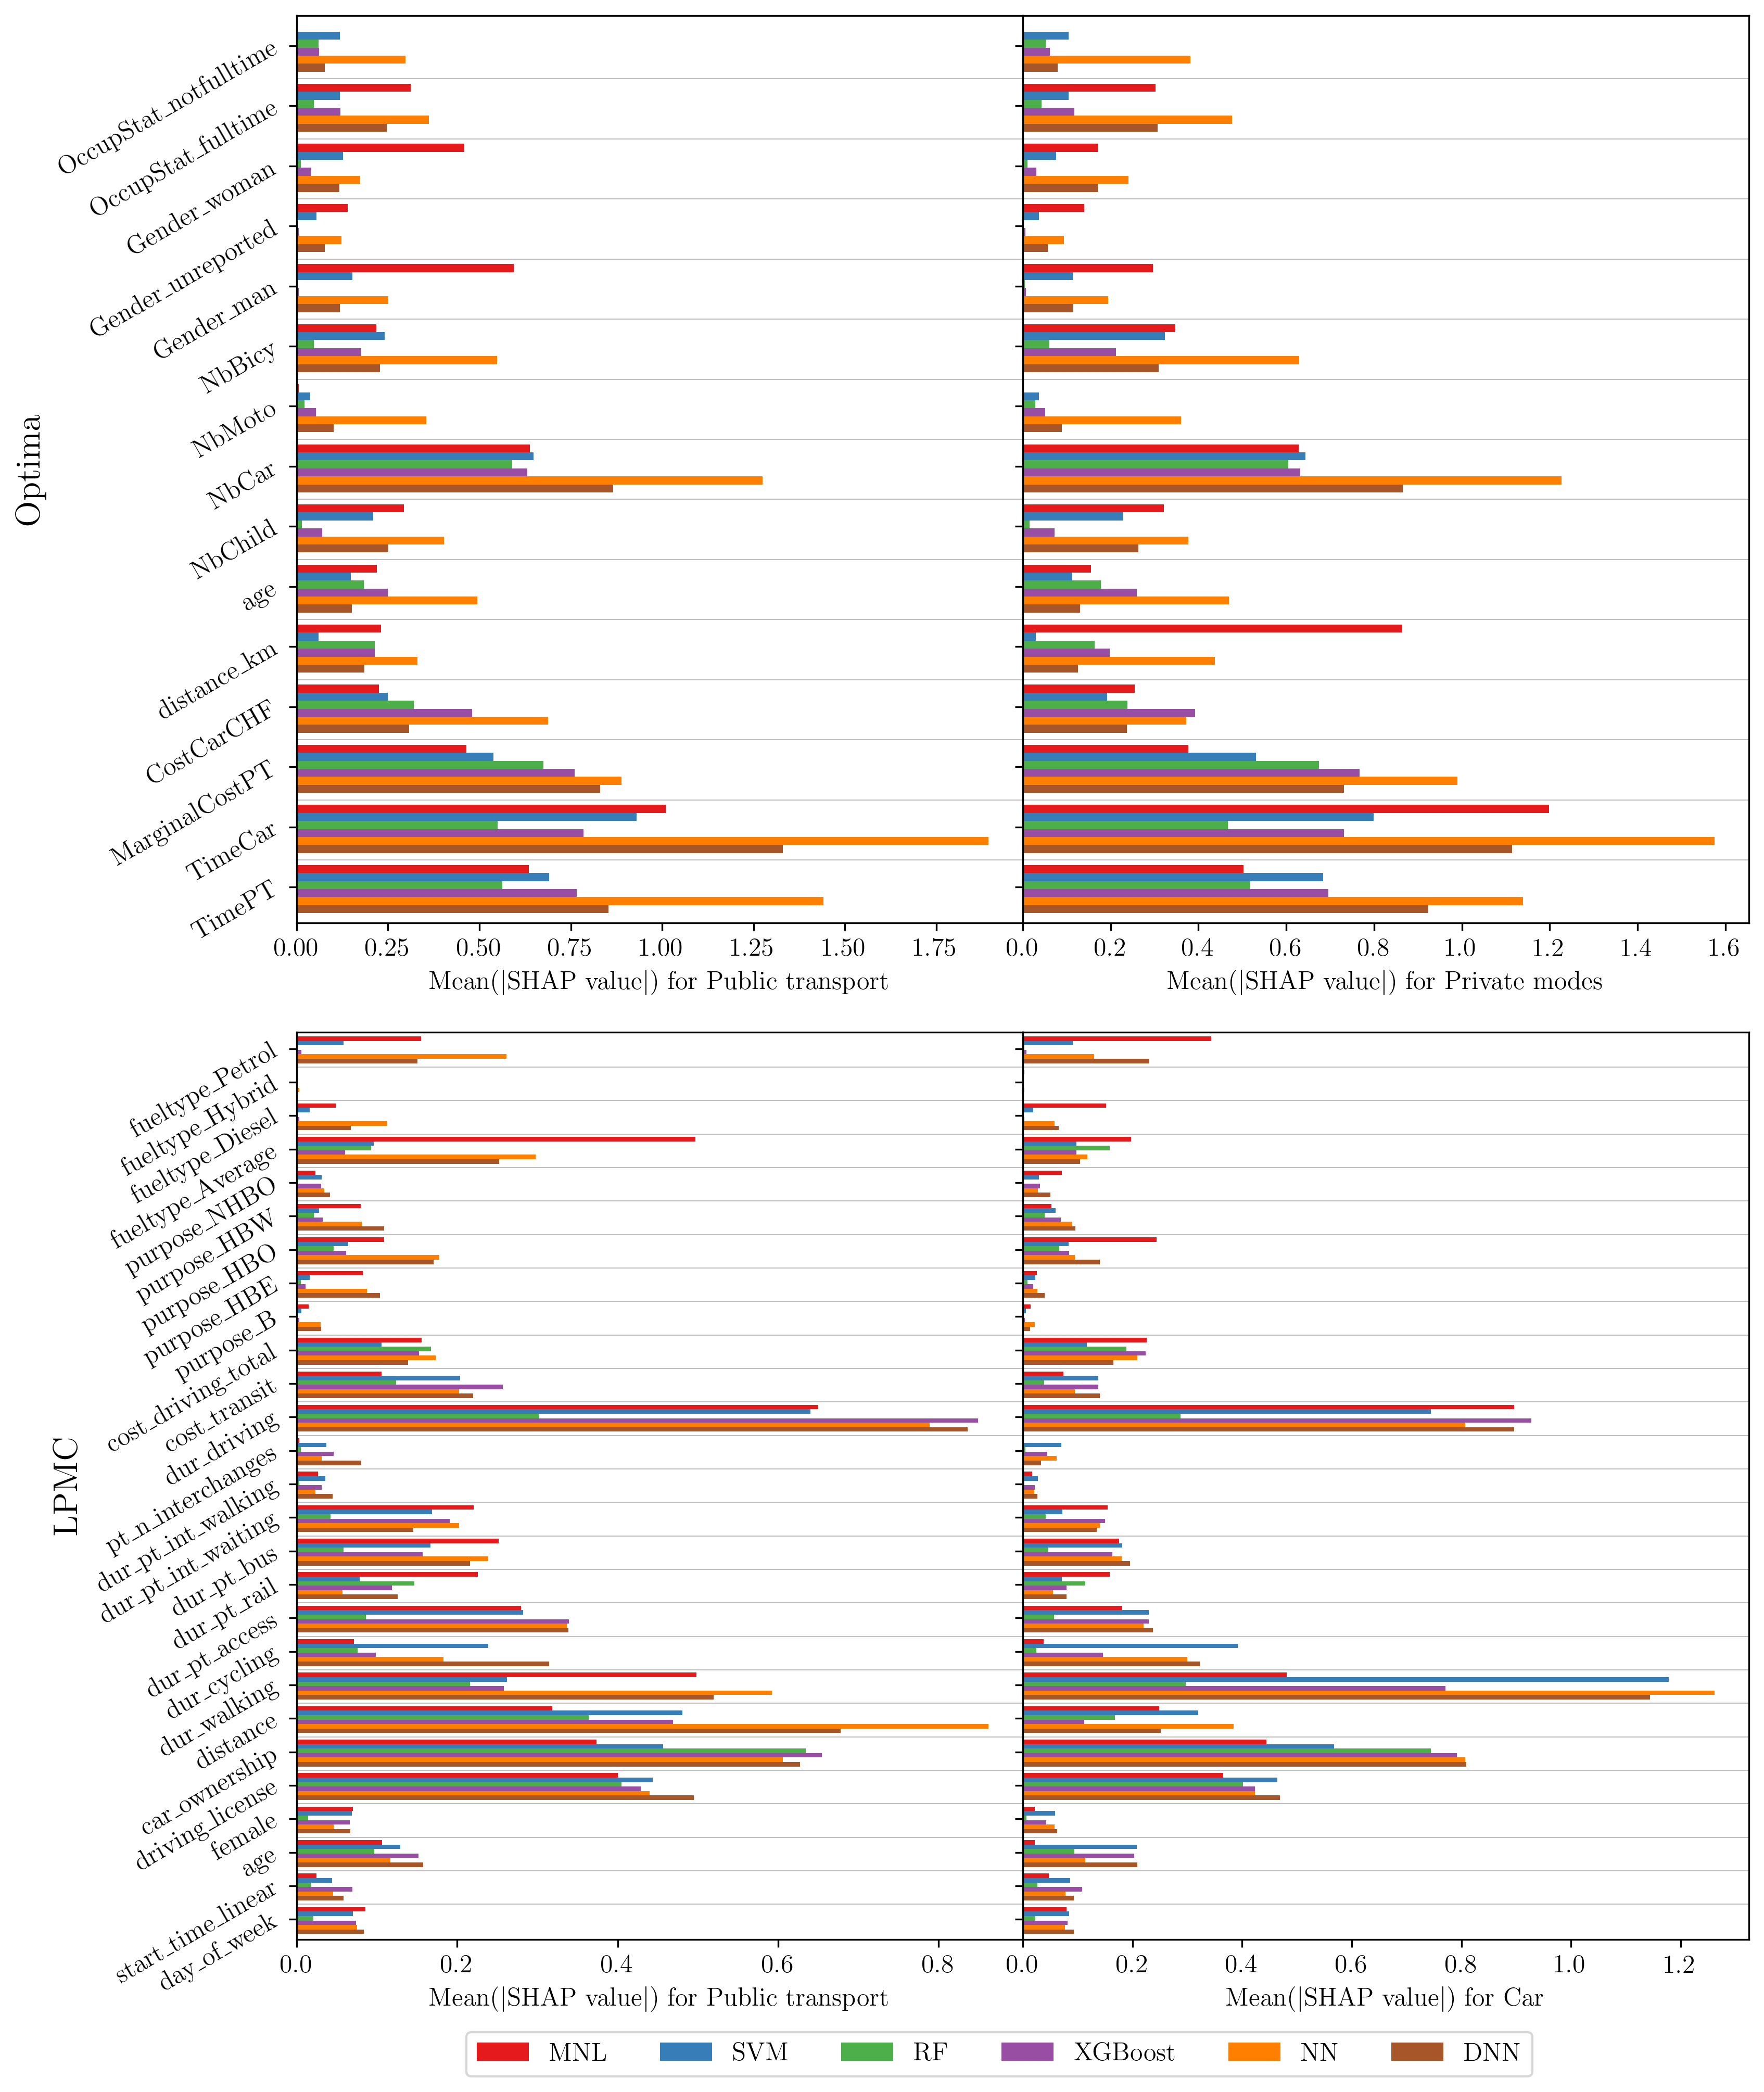

In [40]:
cmap = plt.get_cmap("Set1") # Dark2, Accent, Set1, Set2, Set3, tab10

# Alternatives to be compared per dataset
alternatives_per_dataset = {
    "Optima": {0: "Public transport", 1: "Private modes"},
    #"NTS": {2: "Public transport", 3: "Car"},
    "LPMC": {2: "Public transport", 3: "Car"},
}

fig, axs = plt.subplots(ncols=2, nrows=len(alternatives_per_dataset.keys()), 
                        figsize=(12,16), dpi=300, gridspec_kw = {'wspace':0, 'hspace':0.12})

i = 0
for dataset_name in alternatives_per_dataset.keys():
    print("\n--- {}".format(dataset_name))

    attributes = shap_results[dataset_name]['X_data'].columns
    n_algs = len(shap_results[dataset_name].keys()) - 1
    width = 0.8/n_algs

    # Compute the mean of the absolute value of the SHAP values for each alternative, model and feature
    mean_shap_values = {}
    j = 0
    for alt in alternatives_per_dataset[dataset_name].keys():
        print("\n\t- Alt: {}".format(alt))

        ind = np.arange(len(attributes))
        mean_shap_values[alt] = {}
        classifier_idx = 0
        for classifier in shap_results[dataset_name].keys():
            if classifier == 'X_data':
                continue
            mean_shap_values[alt][classifier] = {}
            for attribute in attributes:
                mean_shap_values[alt][classifier][attribute] = np.mean(np.abs(shap_results[dataset_name][classifier]['shap_values'][alt][:, attributes.get_loc(attribute)]))
        
            # Plot the mean SHAP values for the current classifier
            classifier_shap = mean_shap_values[alt][classifier].values()
            color = classifier_idx
            if color == 5: # Don't use yellow
                color += 1
            axs[i,j].barh(1 + ind - width*classifier_idx, classifier_shap, width, color=cmap(color), label=classifier)

            classifier_idx += 1

        # Format the plot
        axs[i,j].set(yticks=ind + 0.7, ylim=[classifier_idx*width - 0.7, len(attributes)+0.2])

        if j == 0: # Show the feature names and dataset only once
            axs[i,j].set_yticklabels(attributes, rotation=30, ha='right')
            axs[i,j].set_ylabel(dataset_name, fontsize=16)
        else:
            axs[i,j].set_yticklabels([])
        
        axs[i,j].set_xlabel(r"Mean($|$SHAP value$|$) for {}".format(alternatives_per_dataset[dataset_name][alt]), fontsize=12)
        #ax.set_ylabel('Feature')

        # Grey horizontal line to separate the features for better readability
        for k in range(1, len(attributes)):
            axs[i,j].axhline(y=k + 0.15, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

        j += 1 # Next classifier
        
    i += 1 # Next dataset

# Shared legend at the bottom of the plot
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure)

plt.show()
fig.savefig(figures_dir + 'bar_plot/' + 'Comparative.pdf', bbox_inches='tight')

## Bee swarm plots


--- MNL

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


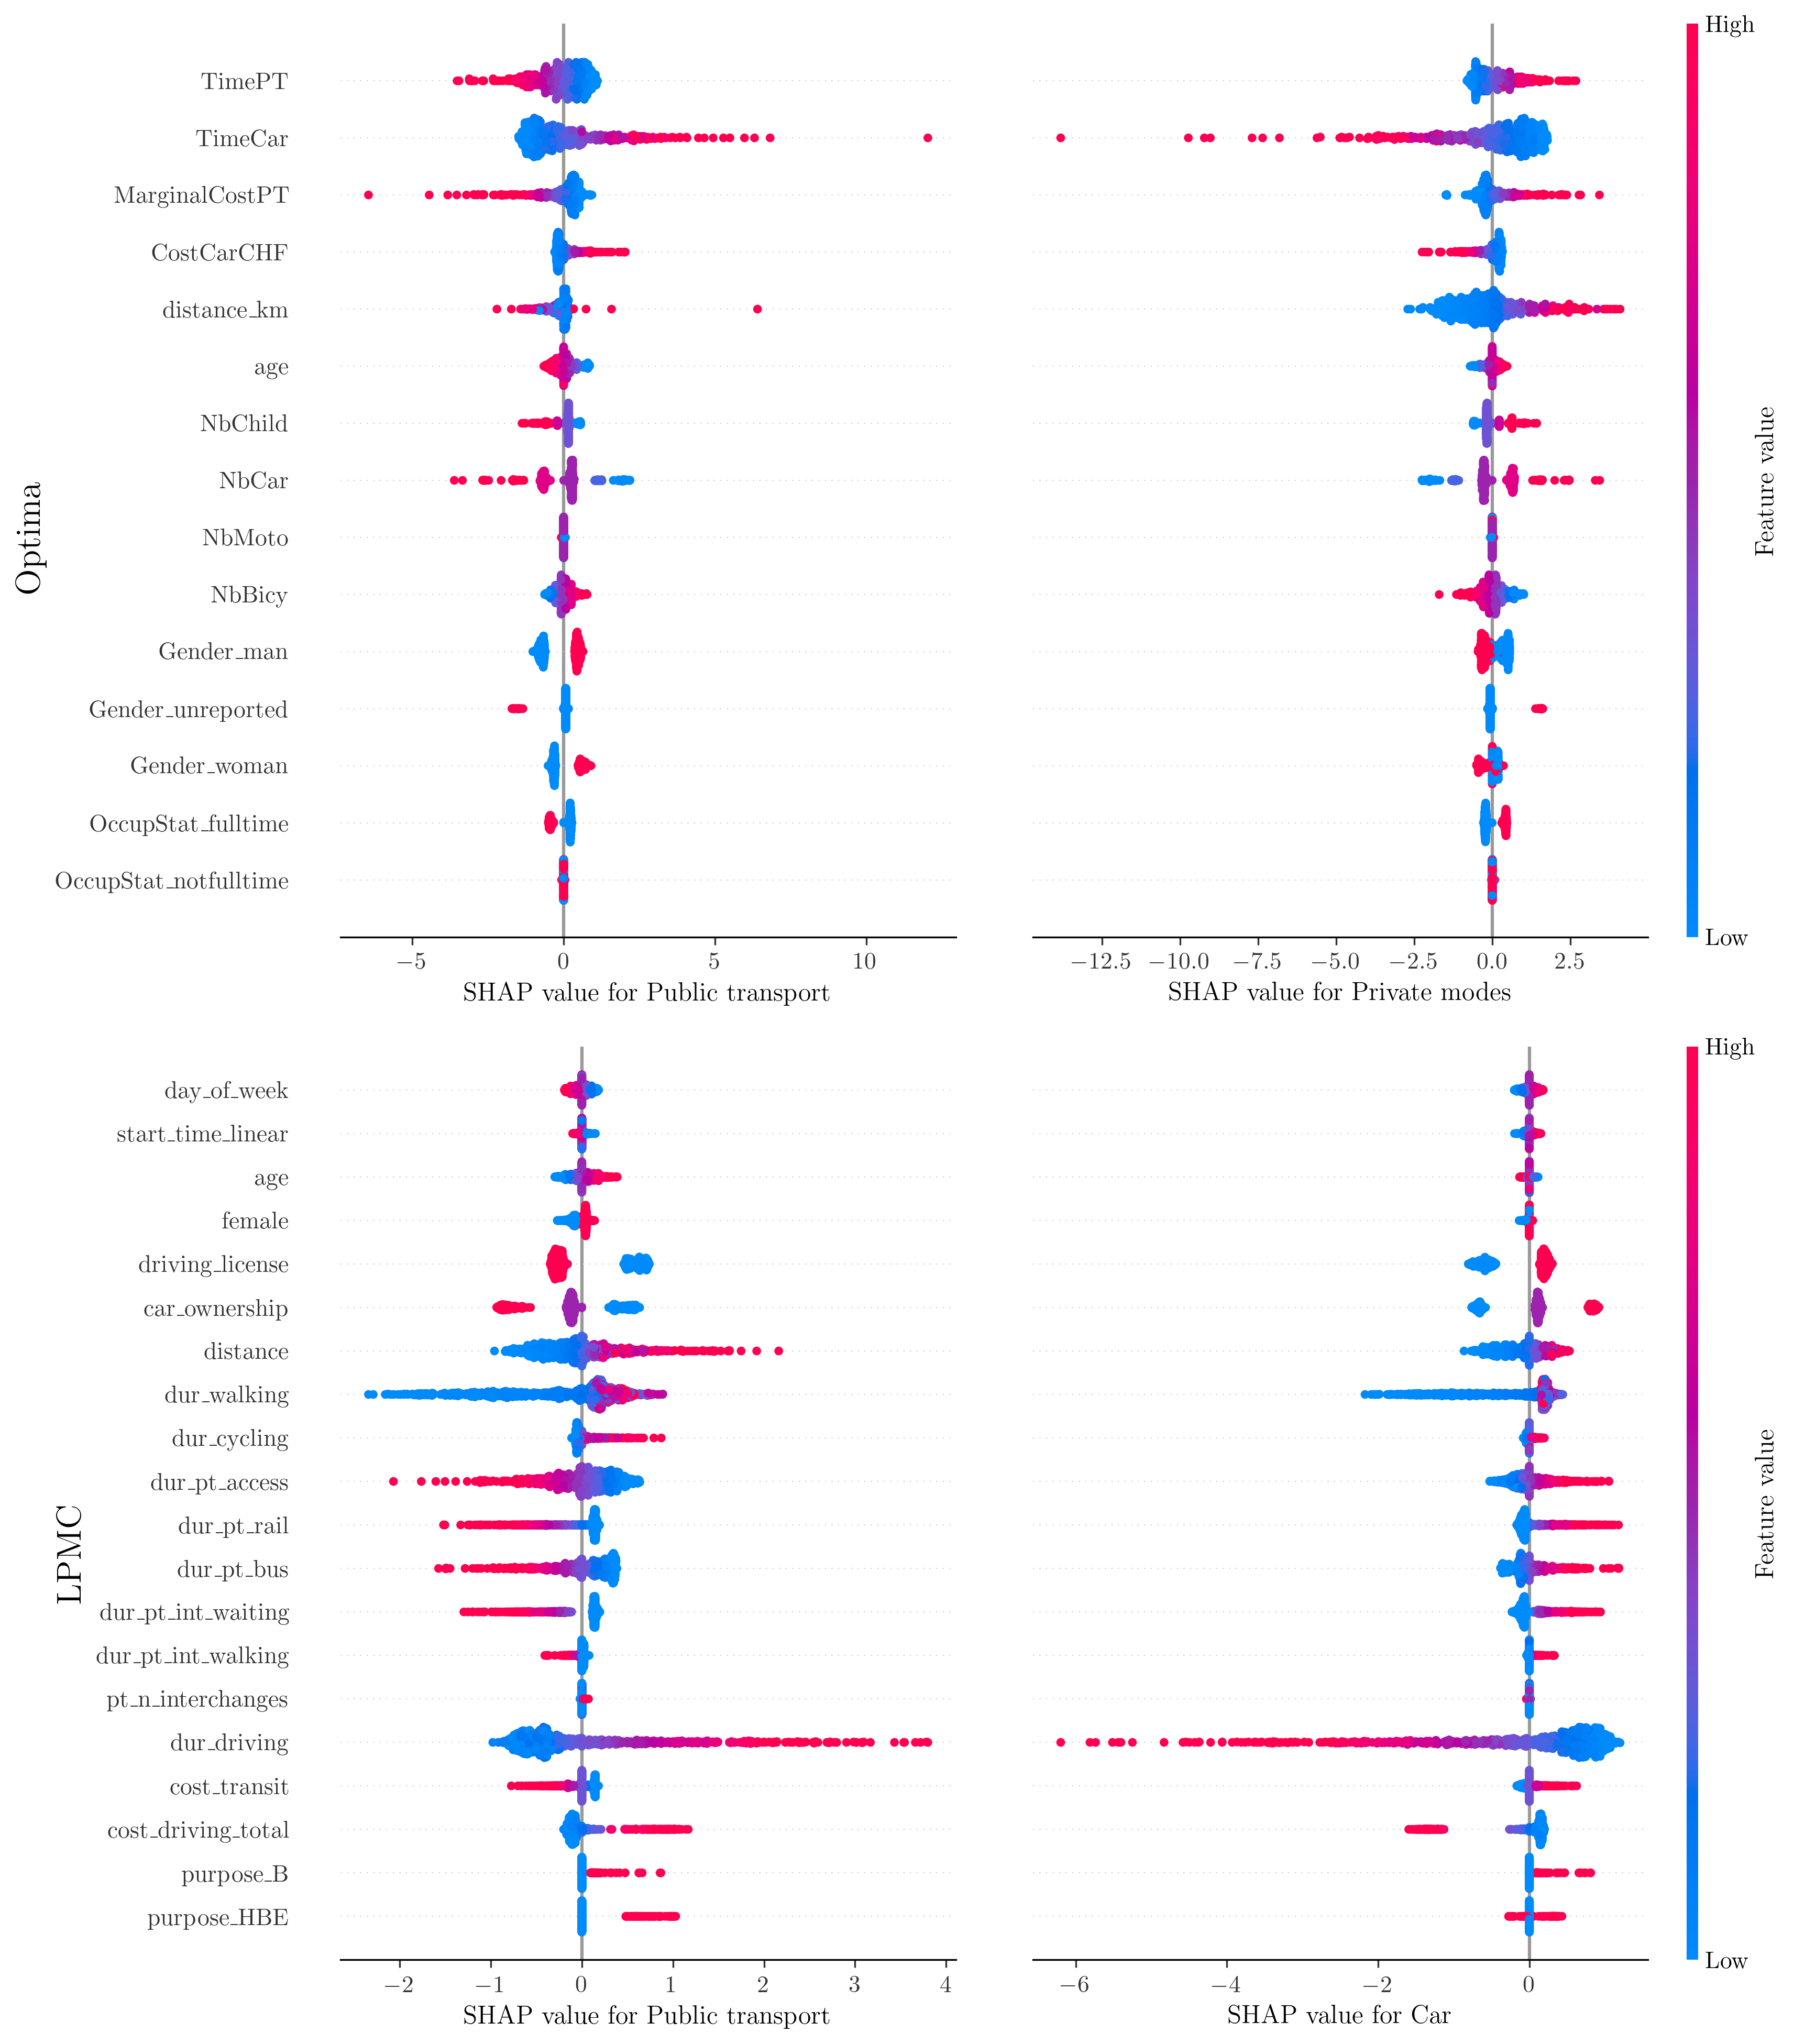


--- SVM

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


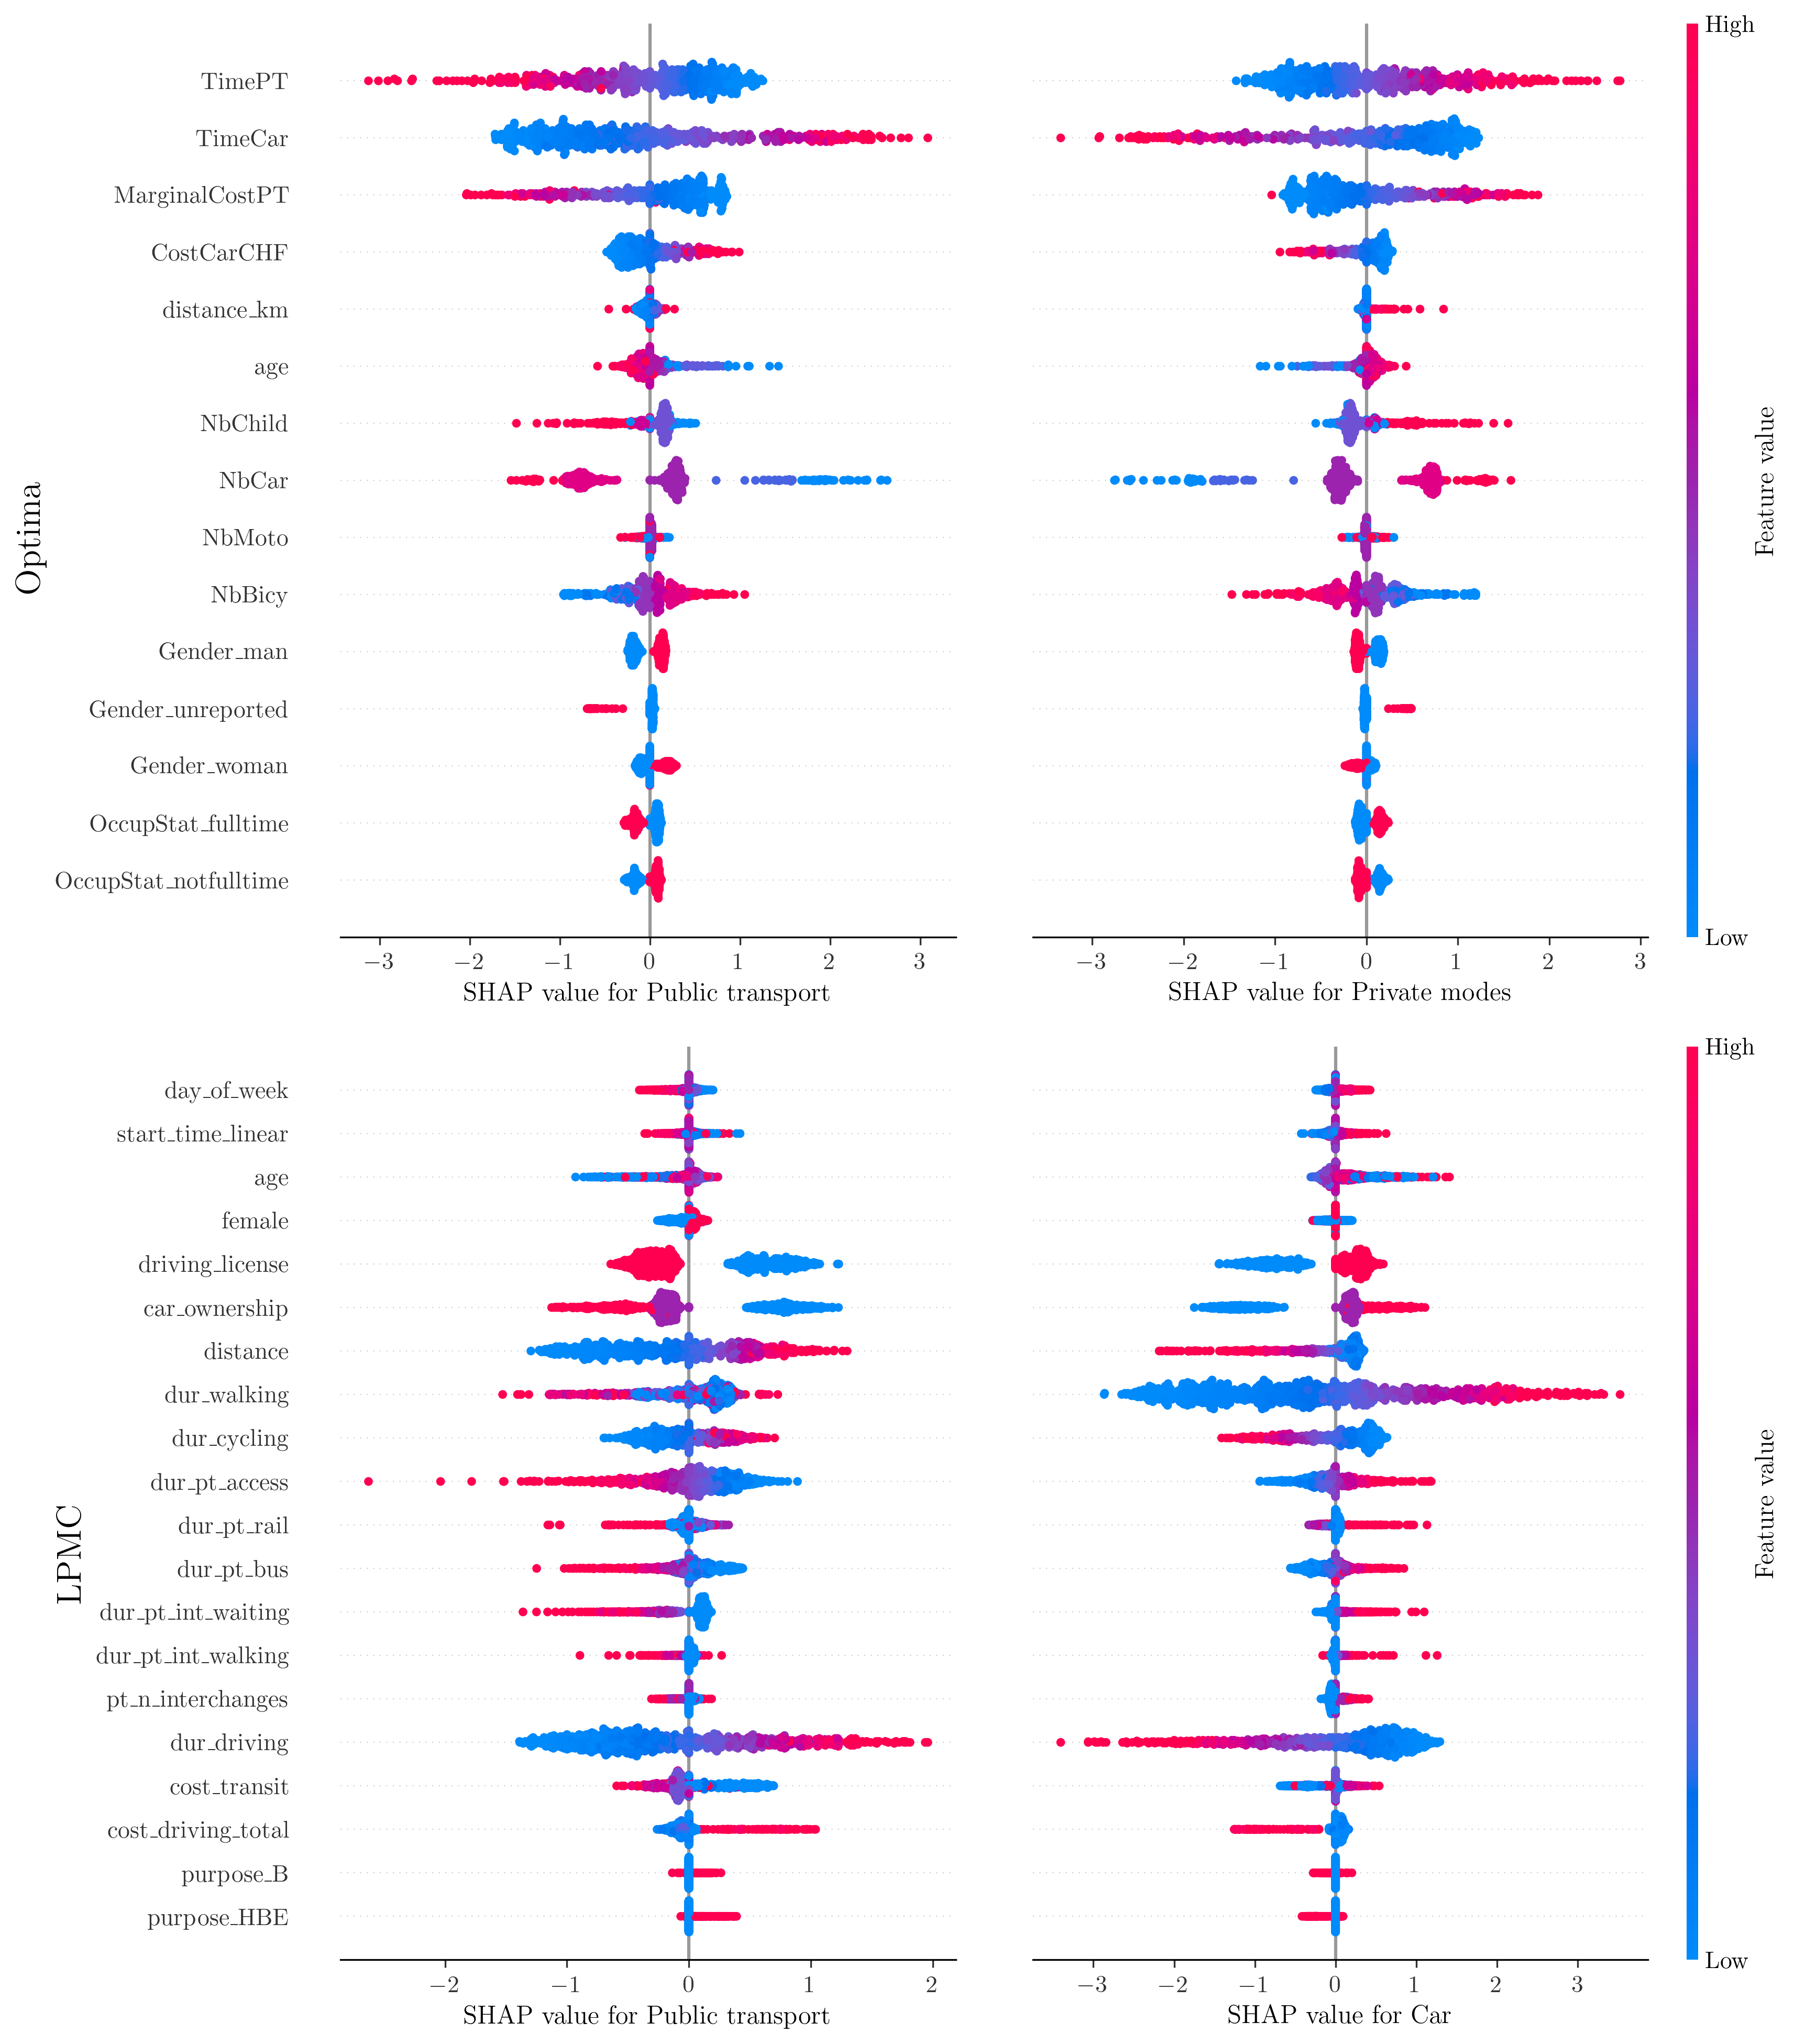


--- RF

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


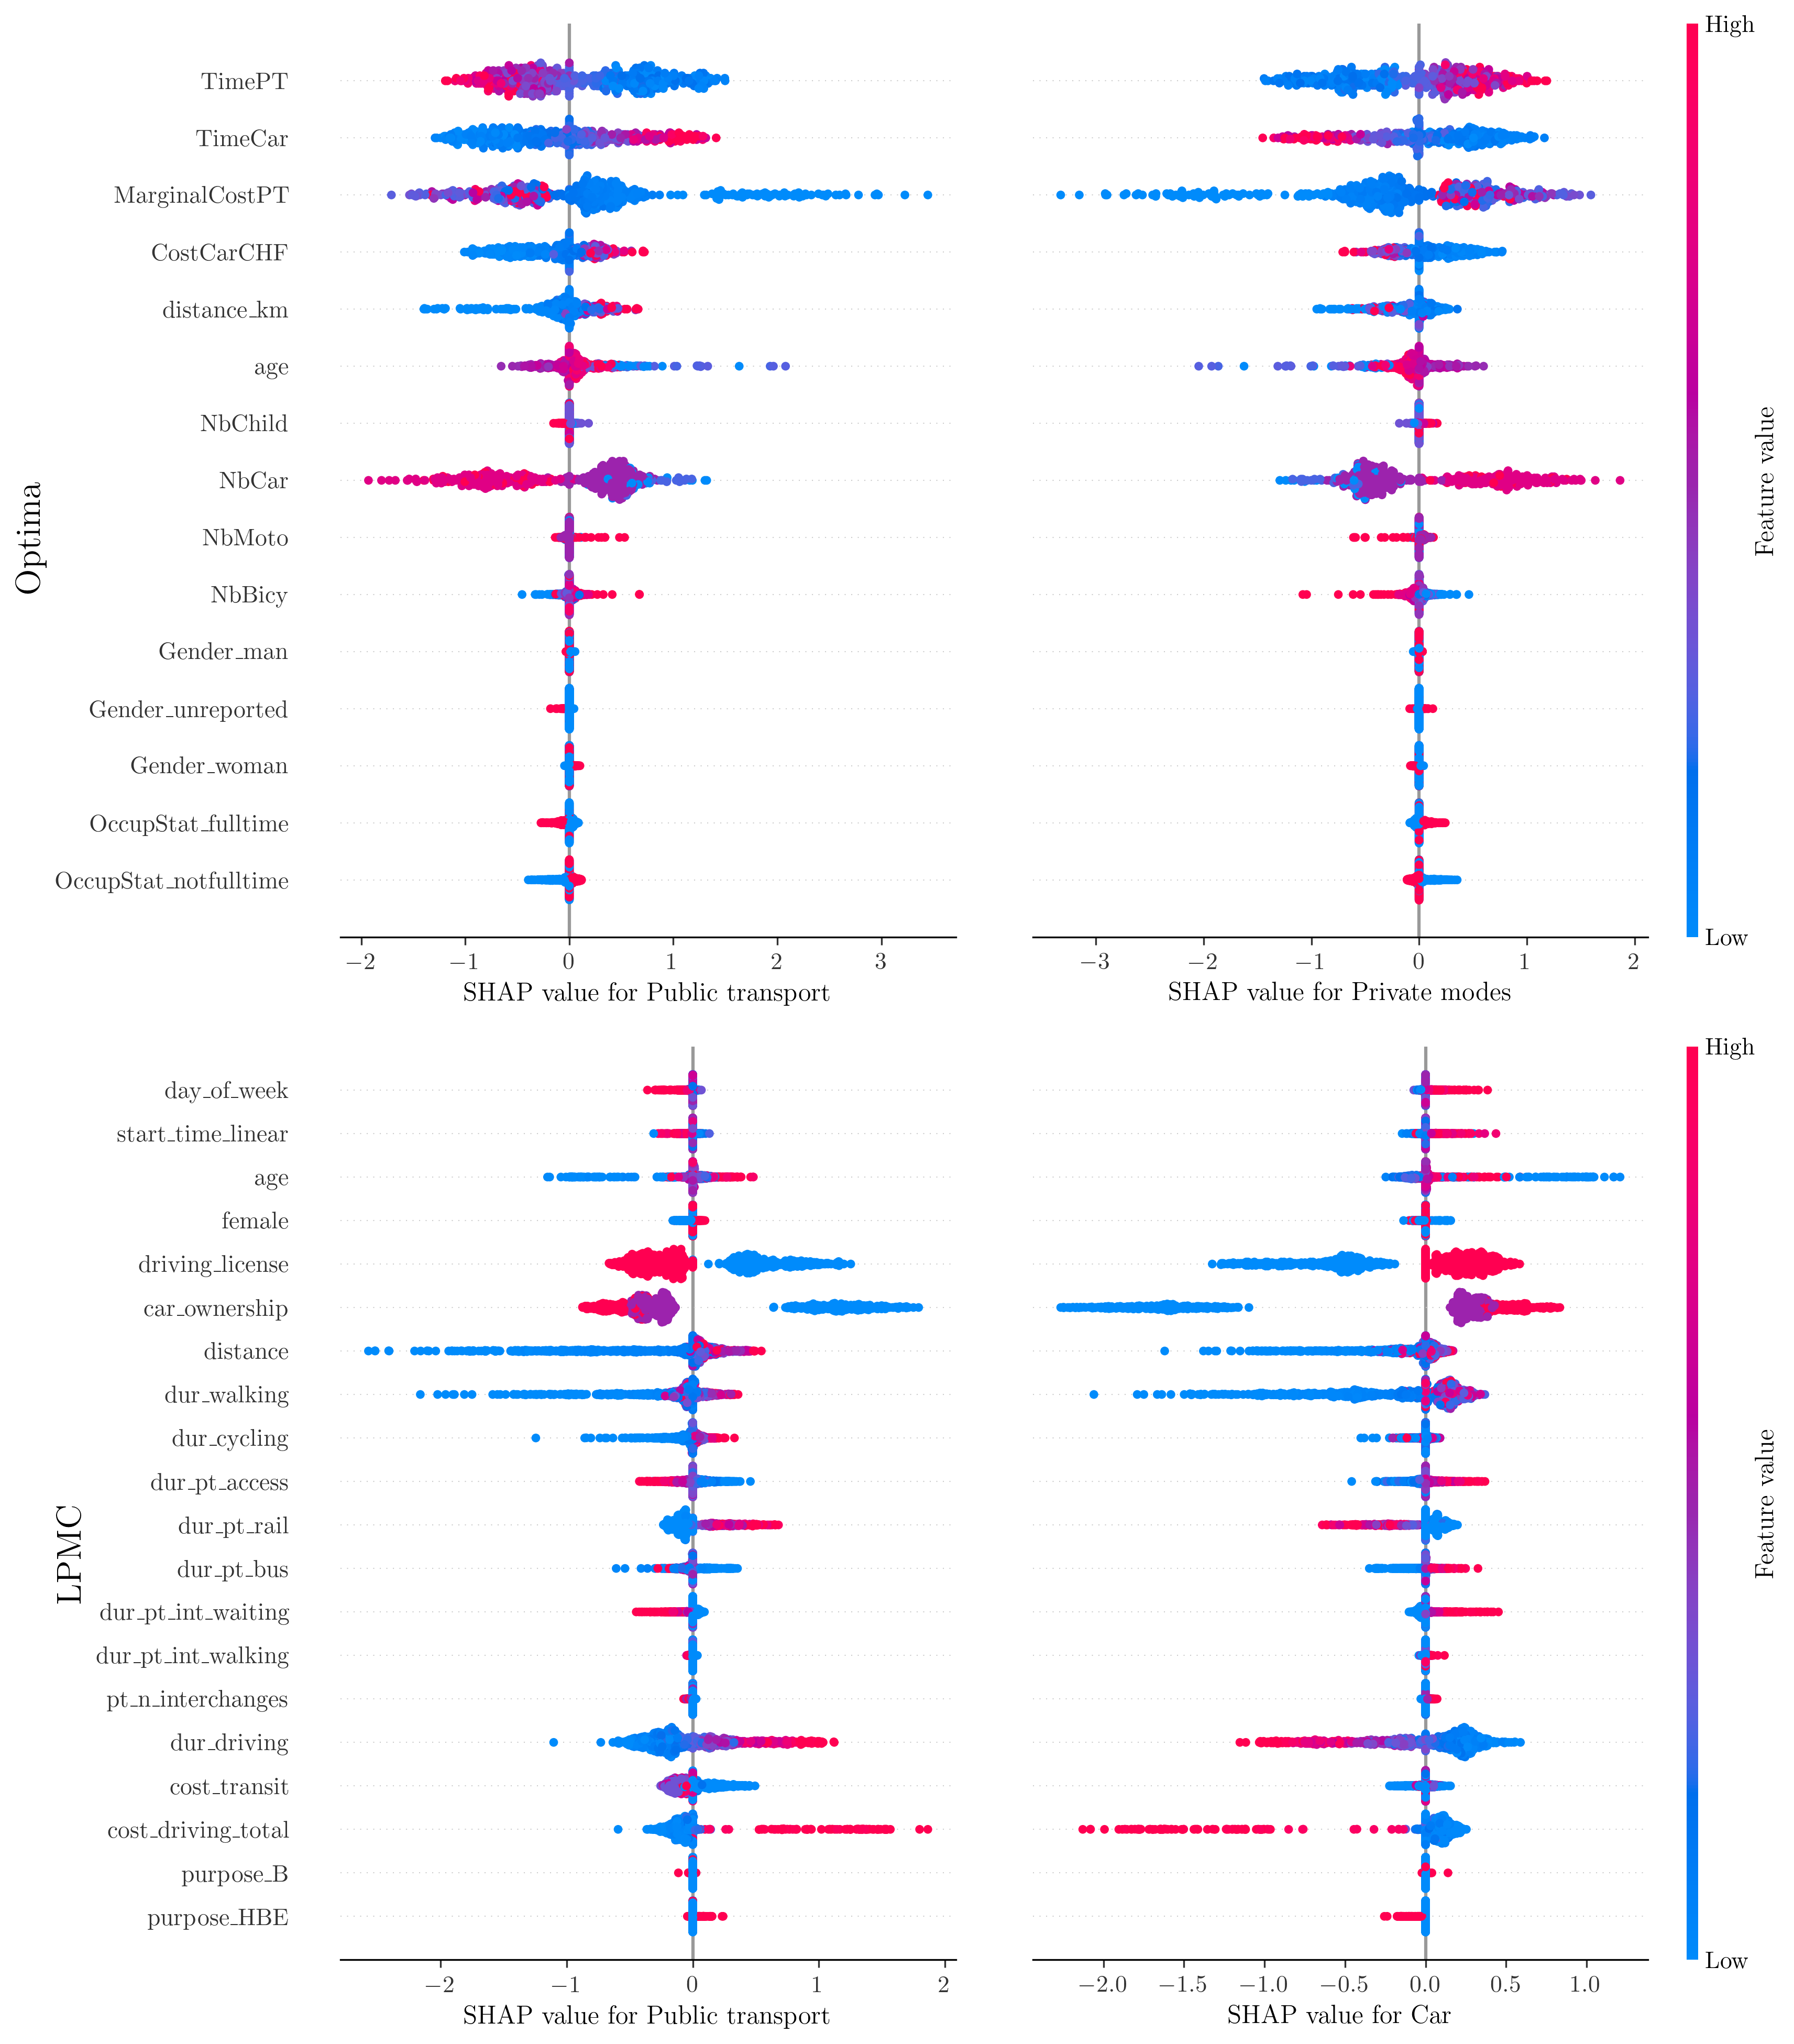


--- XGBoost

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


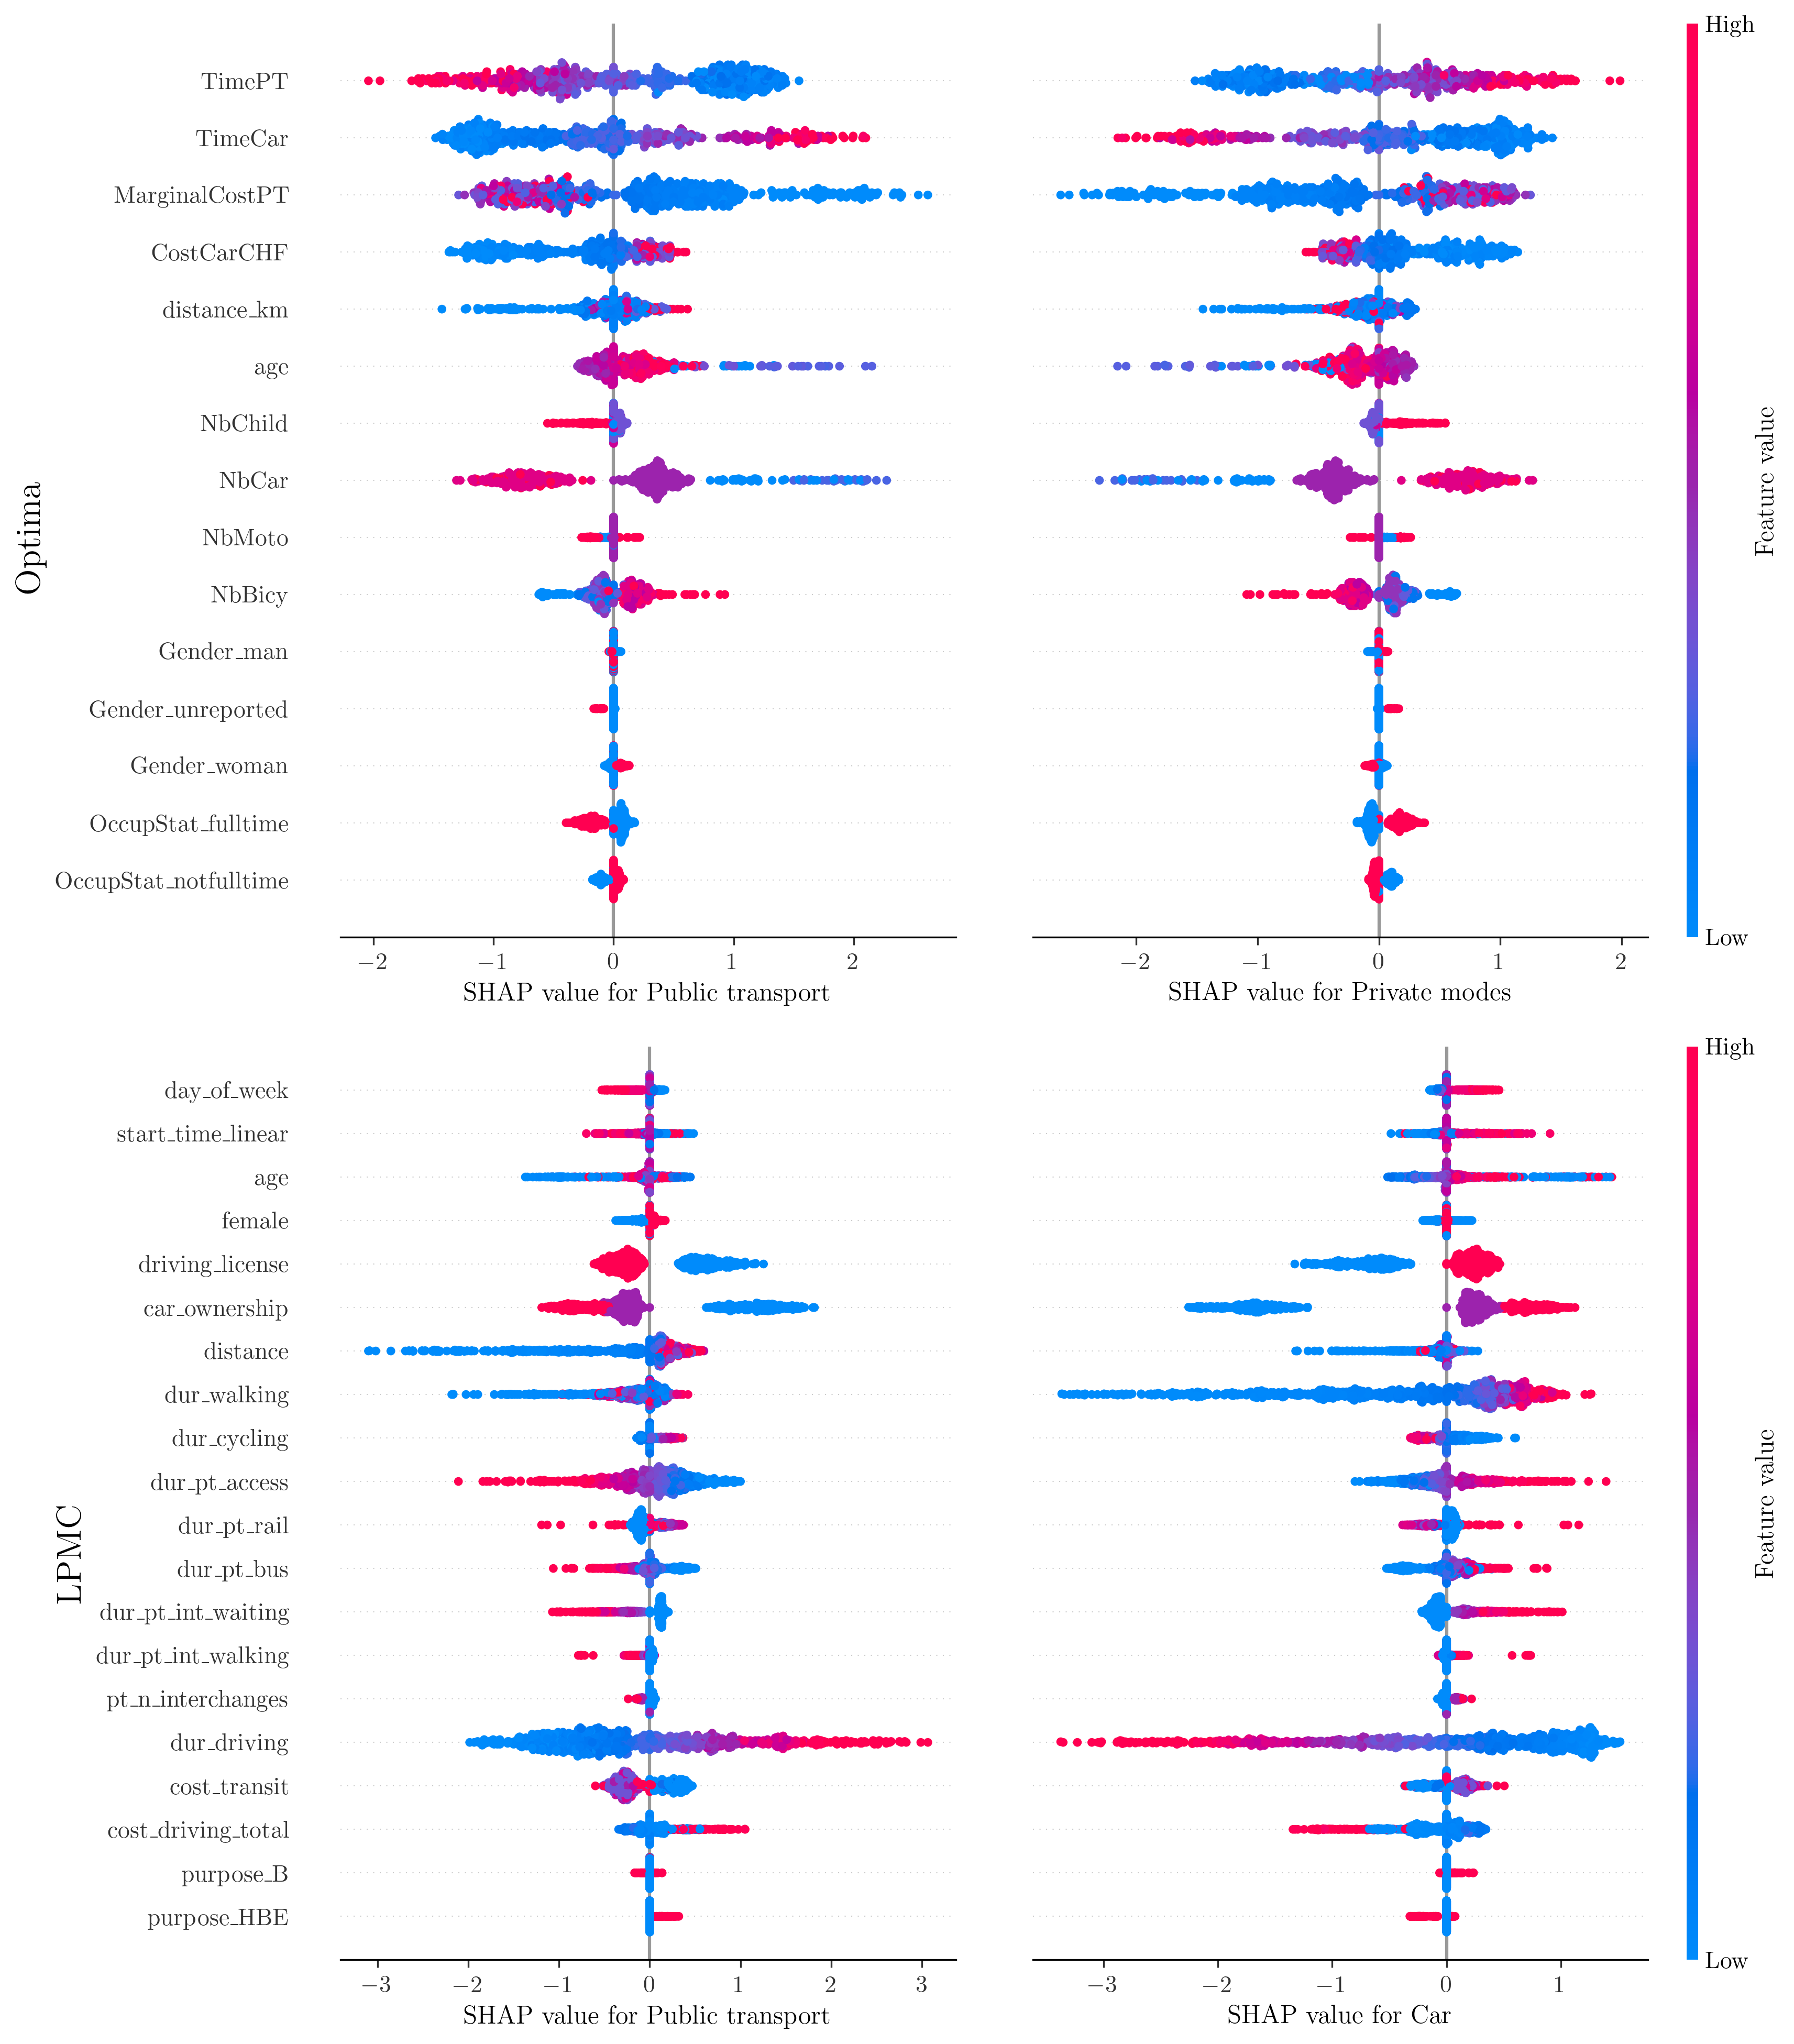


--- NN

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


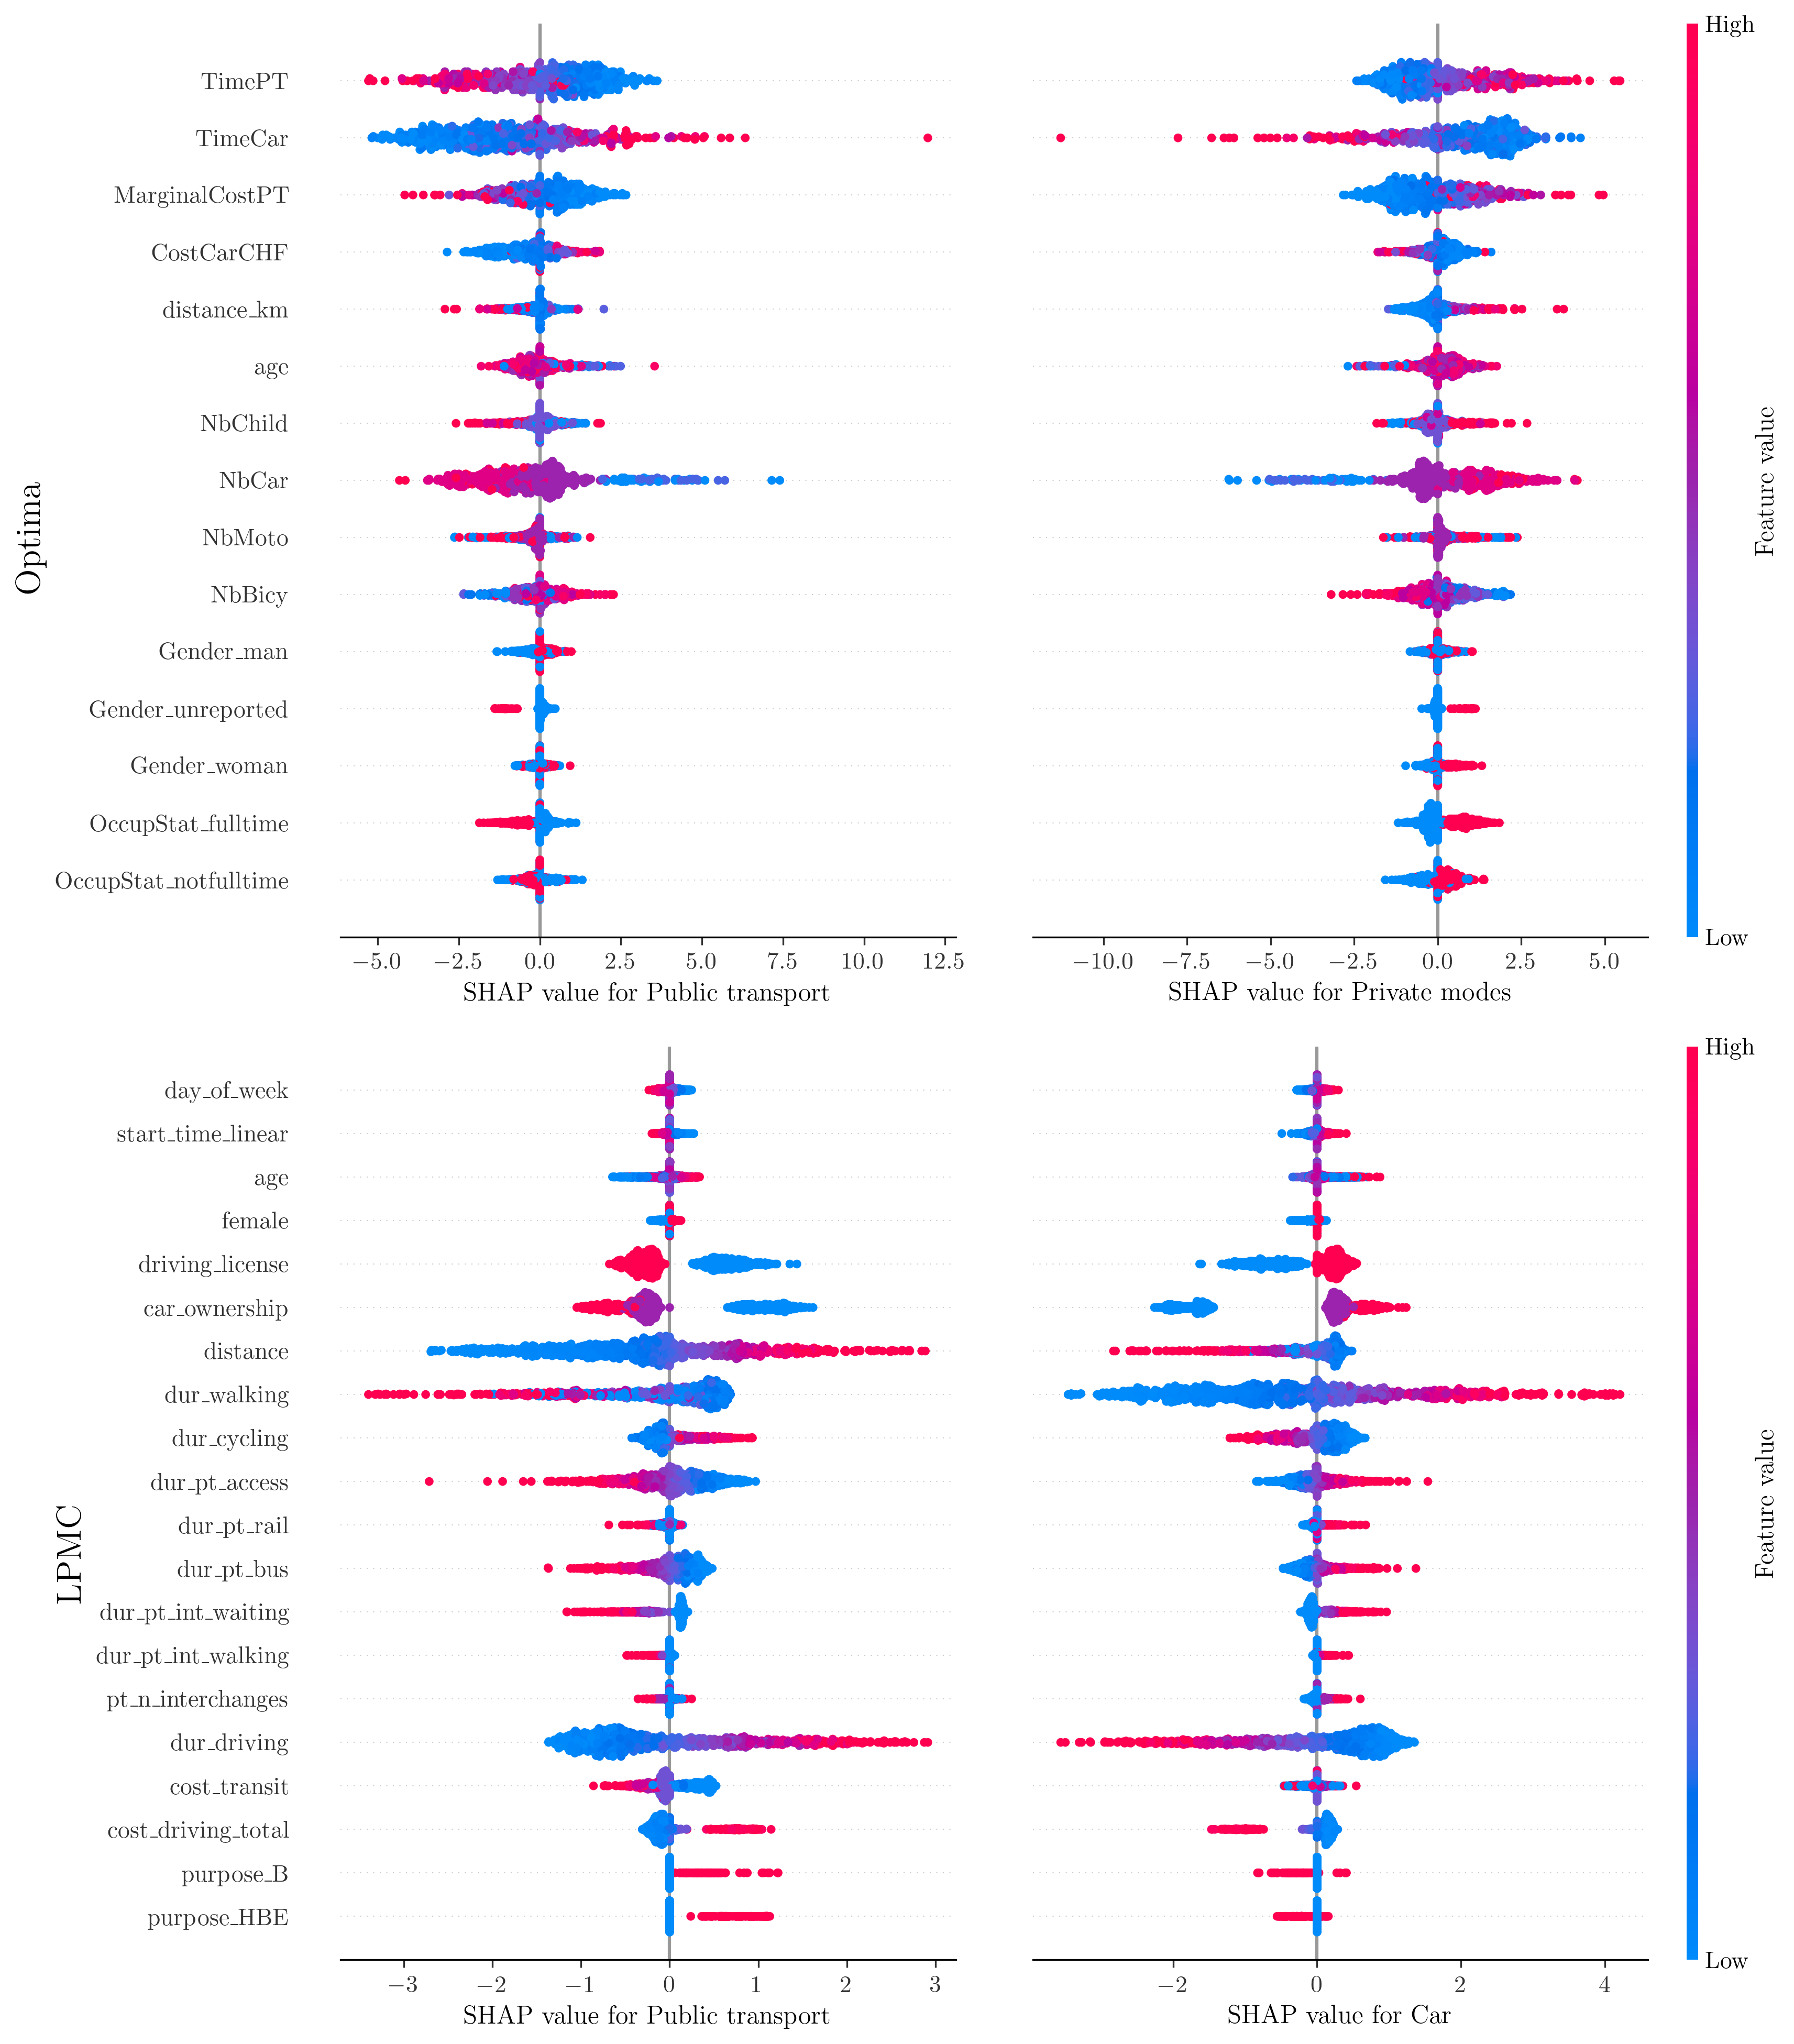


--- DNN

	- Optima

		- Alt: 0

		- Alt: 1

	- LPMC

		- Alt: 2

		- Alt: 3


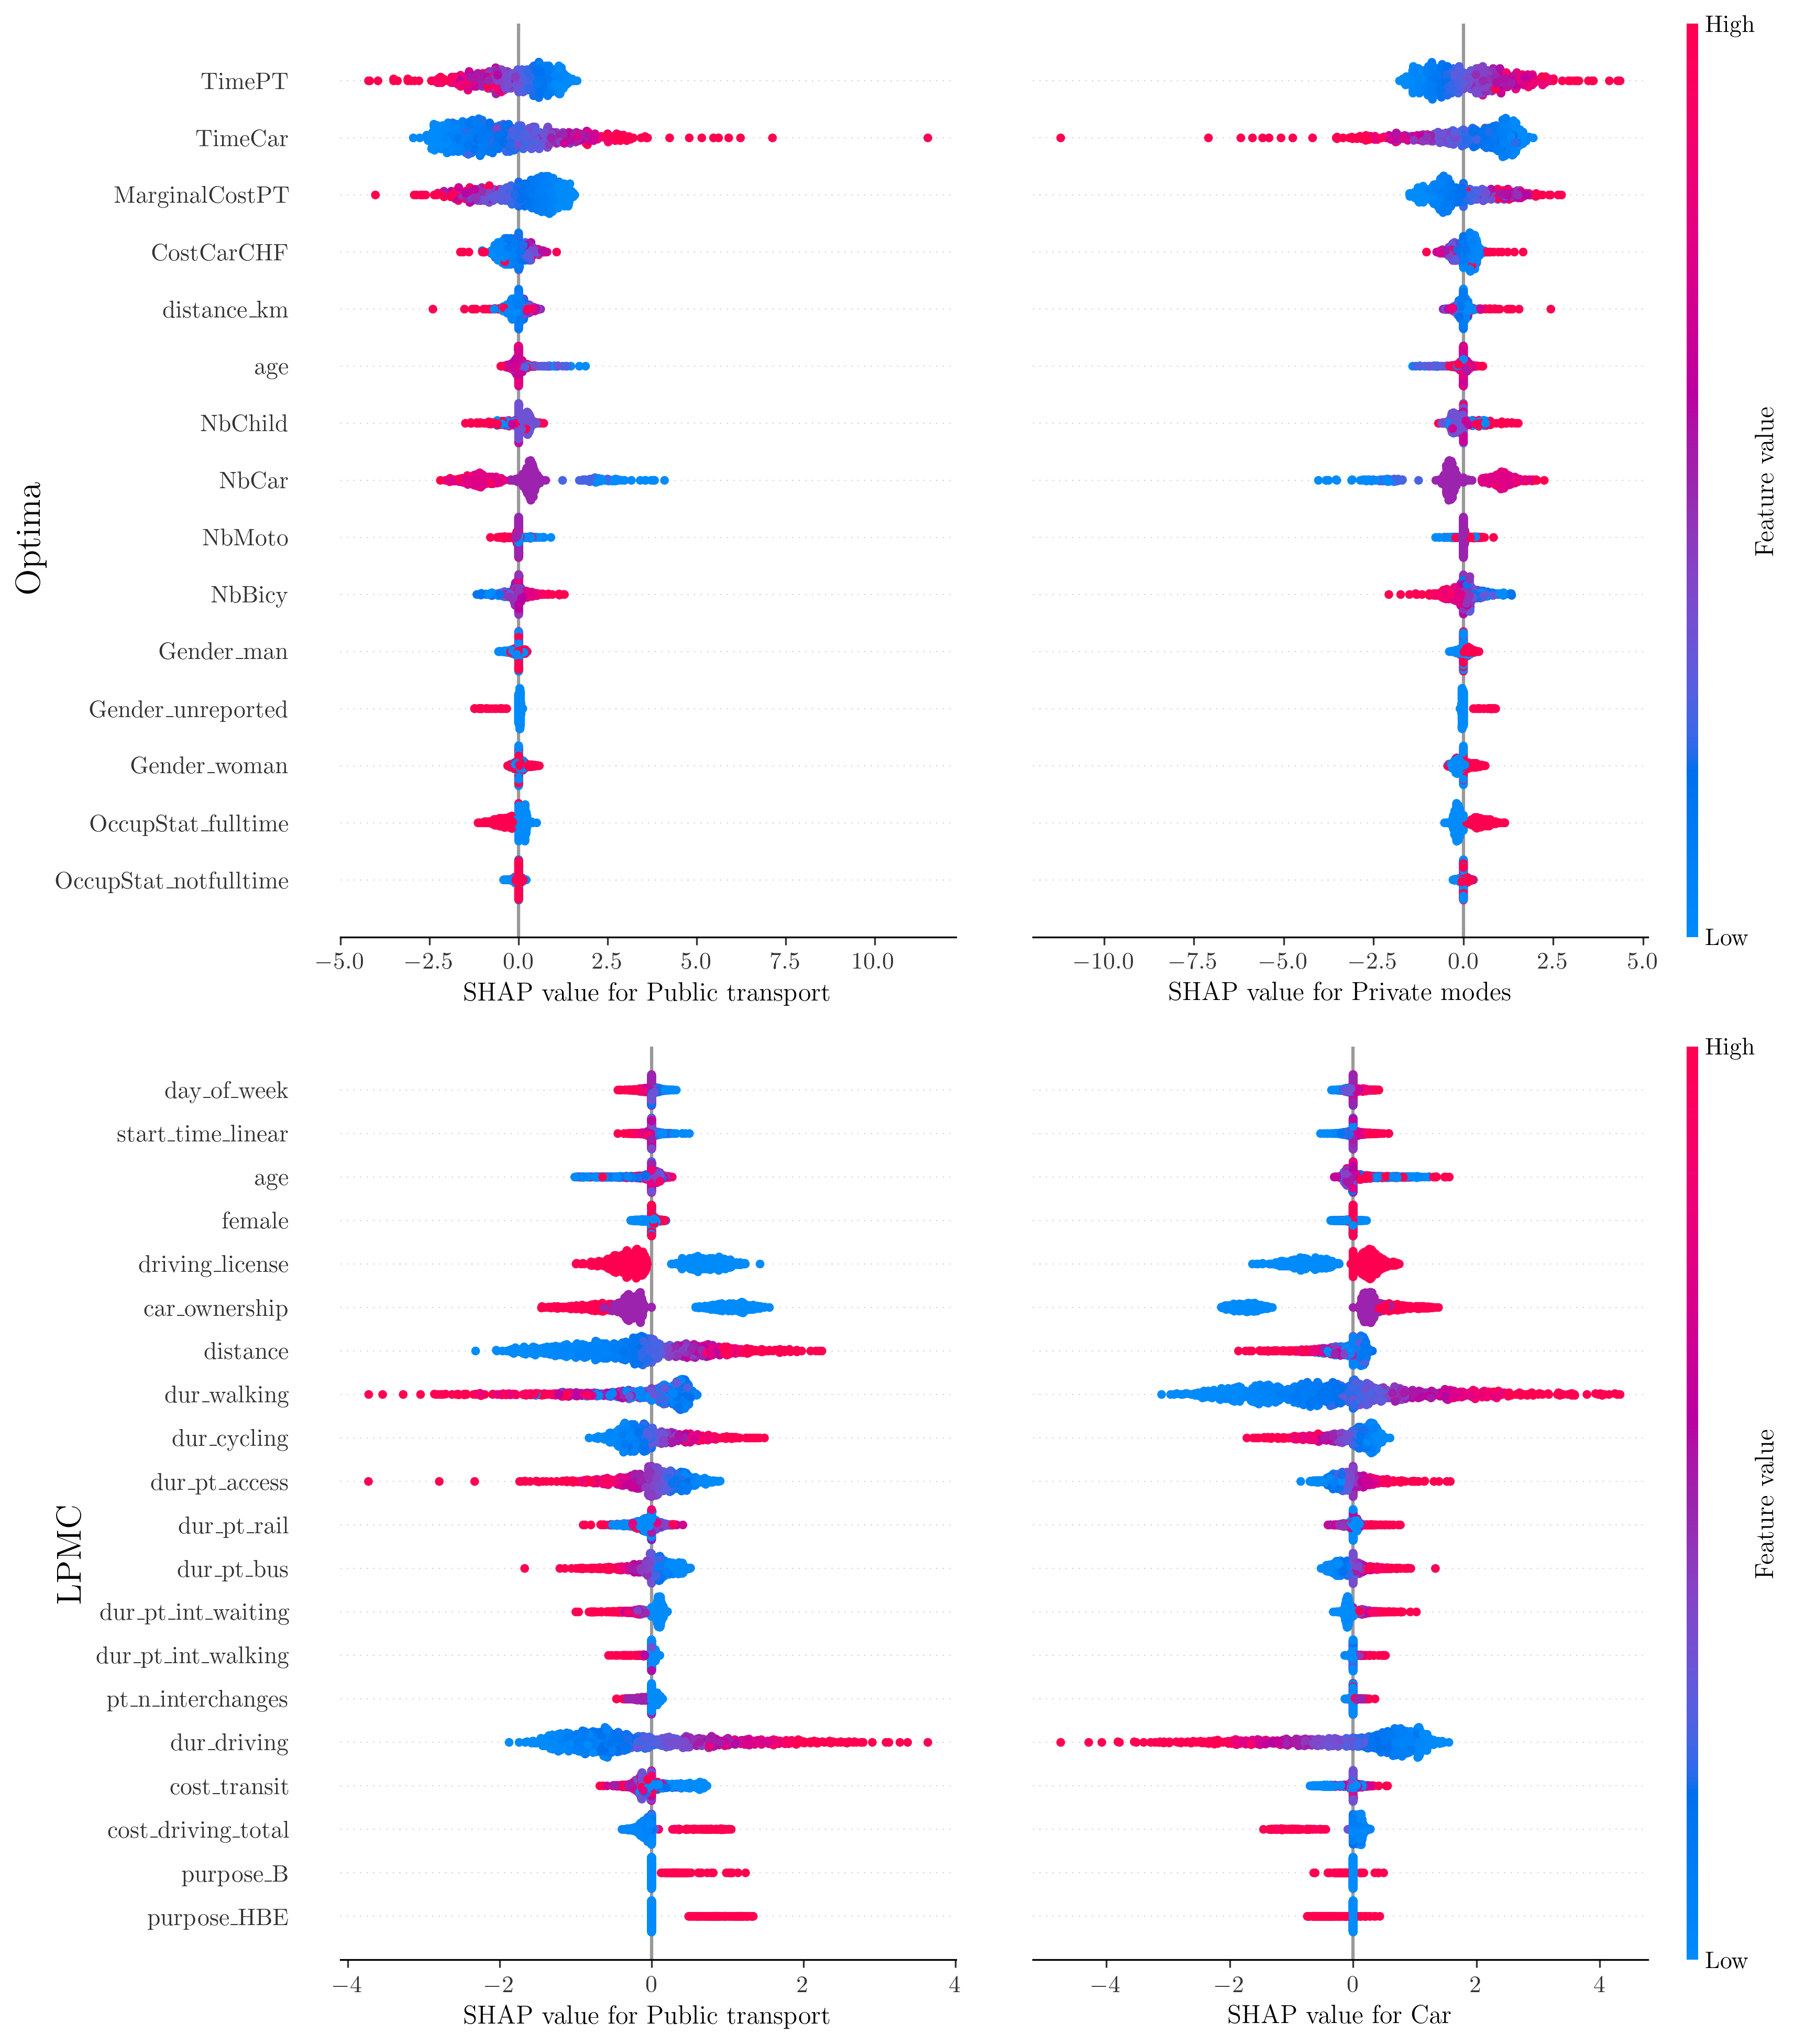

In [43]:
# Generate a bee swarm plot for each dataset and alternative
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Alternatives to be compared per dataset
alternatives_per_dataset = {
    "Optima": {0: "Public transport", 1: "Private modes"},
    #"NTS": {2: "Public transport", 3: "Car"},
    "LPMC": {2: "Public transport", 3: "Car"},
}

classifiers_swarm = ['MNL', 'SVM', 'RF', 'XGBoost', 'NN', 'DNN']

for classifier in classifiers_swarm:
    print("\n--- {}".format(classifier))

    fig, axs = plt.subplots(ncols=2, nrows=len(alternatives_per_dataset.keys()), 
                            figsize=(12,16), dpi=300, gridspec_kw = {'wspace':-0.1, 'hspace':0.12})

    i = 1
    for dataset_name in alternatives_per_dataset.keys():
        print("\n\t- {}".format(dataset_name))

        attributes = shap_results[dataset_name]['X_data'].columns
        first_graph = True
        for alt in alternatives_per_dataset[dataset_name].keys():
            print("\n\t\t- Alt: {}".format(alt))

            #data_alt = pd.DataFrame(shap_results[dataset_name][classifier]['shap_values'][alt], columns=attributes)

            if first_graph:
                feature_names = attributes
            else:
                feature_names = [""]*len(attributes)

            plt.subplot(2,2,i)
            shap.summary_plot(shap_results[dataset_name][classifier]['shap_values'][alt], shap_results[dataset_name]['X_data'], feature_names=feature_names,
                  sort=False, plot_size=None, show=False)
            
            if first_graph:
                # Remove colorbar and recover the size of the plot
                plt.gcf().axes[-1].remove()
                # Add dataset name to the left of the plot
                plt.ylabel(dataset_name, fontsize=16, rotation=90, ha='right')
                first_graph = False
            
            # Configure plot
            plt.xlabel("SHAP value for {}".format(alternatives_per_dataset[dataset_name][alt]), fontsize=12)
            # Rotate the y labels 
            plt.yticks(rotation=0, ha='right', fontsize=11)
            
            i += 1

    plt.show()
    fig.savefig(figures_dir + 'beeswarm_plot/' + '{}_beeswarm.pdf'.format(classifier), bbox_inches='tight')
        

# Obtain MNL coefficients table

In [10]:
# Obtain MNL coefficients table
for dataset_name in shap_results.keys():
    print("\n--- {}".format(dataset_name))
    
    MNL_coefficients = shap_results[dataset_name]['MNL']['MNL_coefs']
    
    # Round the coefficients to 3 decimal places
    MNL_coefficients = MNL_coefficients[['Value', 'Std err', 'p-value']].round(3)

    # Insert \ before the _ in the index for latex compatibility
    MNL_coefficients.index = MNL_coefficients.index.str.replace('_', '\_')

    # Add a column that indicates the statistical significance of the coefficients
    MNL_coefficients['Significance'] = MNL_coefficients['p-value'].apply(
        lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))

    display(MNL_coefficients)
    ## Export tables as latex code
    pandas_to_latex(MNL_coefficients, "Latex_tables/experiment_5_MNL_coefs_{}.tex".format(dataset_name),
                    align_rest='l', index = True, multicolumn=False, fit_width=False, 
                    caption="MNL coefficients estimated for the {} dataset".format(dataset_name),
                    label="tab:experiment_5_MNL_coefs_{}".format(dataset_name))



--- Optima


Value  Std err  p-value Significance
ASC\_PM                     1.200    0.083    0.000          ***
ASC\_SM                    -6.732    0.822    0.000          ***
B\_CostCarCHF\_PM          -0.615    1.031    0.551             
B\_Gender\_man\_PM         -0.066    0.043    0.129             
B\_Gender\_man\_PT          0.151    0.048    0.002           **
B\_Gender\_man\_SM         -0.085    0.073    0.245             
B\_Gender\_unreported\_PM   0.161    0.083    0.052             
B\_Gender\_unreported\_PT  -0.480    0.096    0.000          ***
B\_Gender\_unreported\_SM   0.319    0.139    0.022            *
B\_Gender\_woman\_PM       -0.003    0.034    0.931             
B\_Gender\_woman\_PT        0.054    0.038    0.153             
B\_Gender\_woman\_SM       -0.051    0.056    0.363             
B\_MarginalCostPT\_PT      -1.062    0.157    0.000          ***
B\_NbBicy\_PM              -0.502    0.076    0.000          ***
B\_NbBicy\_PT              -0.056    0.083    0.499             
B\_NbBicy\_SM               0.558    0.117    0.000          ***
B\_NbCar\_PM                0.524    0.081    0.000          ***
B\_NbCar\_PT               -0.459    0.093    0.000          ***
B\_NbCar\_SM               -0.065    0.132    0.623             
B\_NbChild\_PM              0.336    0.074    0.000          ***
B\_NbChild\_PT             -0.178    0.083    0.032            *
B\_NbChild\_SM             -0.157    0.117    0.180             
B\_NbMoto\_PM              -0.003    0.056    0.957             
B\_NbMoto\_PT              -0.018    0.064    0.779             
B\_NbMoto\_SM               0.021    0.088    0.811             
B\_OccupStat\_fulltime\_PM  0.201    0.071    0.005           **
B\_OccupStat\_fulltime\_PT -0.203    0.079    0.010            *
B\_OccupStat\_fulltime\_SM  0.002    0.120    0.987             
B\_TimeCar\_PM             -2.837    0.394    0.000          ***
B\_TimePT\_PT              -1.129    0.175    0.000          ***
B\_age\_PM                  0.055    0.085    0.516             
B\_age\_PT                 -0.291    0.092    0.002           **
B\_age\_SM                  0.236    0.148    0.112             
B\_distance\_km\_PM         5.466    0.821    0.000          ***
B\_distance\_km\_PT         4.060    0.577    0.000          ***
B\_distance\_km\_SM        -9.526    1.090    0.000          ***


--- NTS


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Value  Std err  p-value Significance
ASC\_Bike                   3.526    0.071    0.000          ***
ASC\_Car                    5.330    0.070    0.000          ***
ASC\_Public\_Transport      2.152    0.076    0.000          ***
B\_age\_Bike                0.115    0.009    0.000          ***
B\_age\_Car                 0.092    0.008    0.000          ***
...                           ...      ...      ...          ...
B\_western\_Walk           -0.010    0.007    0.123             
B\_wind\_Bike              -0.025    0.009    0.006           **
B\_wind\_Car                0.026    0.008    0.002           **
B\_wind\_Public\_Transport -0.009    0.017    0.588             
B\_wind\_Walk               0.008    0.010    0.424             

[75 rows x 4 columns]


--- LPMC


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


Value  Std err  p-value  \
ASC\_Bike                                  2.738    0.085    0.000   
ASC\_Car                                   5.542    0.078    0.000   
ASC\_Public\_Transport                     5.387    0.078    0.000   
B\_age\_Bike                              -0.138    0.026    0.000   
B\_age\_Car                                0.048    0.012    0.000   
...                                          ...      ...      ...   
B\_purpose\_NHBO\_Walk                     0.069    0.011    0.000   
B\_start\_time\_linear\_Bike               0.020    0.020    0.319   
B\_start\_time\_linear\_Car                0.051    0.010    0.000   
B\_start\_time\_linear\_Public\_Transport -0.014    0.011    0.173   
B\_start\_time\_linear\_Walk              -0.056    0.014    0.000   

                                          Significance  
ASC\_Bike                                          ***  
ASC\_Car                                           ***  
ASC\_Public\_Transport                             ***  
B\_age\_Bike                                       ***  
B\_age\_Car                                        ***  
...                                                ...  
B\_purpose\_NHBO\_Walk                             ***  
B\_start\_time\_linear\_Bike                            
B\_start\_time\_linear\_Car                        ***  
B\_start\_time\_linear\_Public\_Transport               
B\_start\_time\_linear\_Walk                       ***  

[76 rows x 4 columns]

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
